Problem definition:
---------------------------
For the challenge, we will use datacollected by the New York City Taxi and Limousine commission about “Green” Taxis. Green Taxis (as opposed to yellow ones) are taxis that are not allowed to pick up passengers inside of the densely populated areas of Manhattan. We will use the data from September 2015. We are using NYC Taxi and Limousine trip record data: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

<a id='outline'></a>
Required Questions:
------------------------------
### 1. <a href='#Section.1'> Question 1</a>

* 1.1 <a href='#Section.1.1'> Programmatically download and load into your favorite analytical tool the trip data for September 2015</a>.

* 1.2 <a href='#Section.1.2'> Report how many rows and columns of data you have loaded</a>.

### 2. <a href='#Section.2'> Question 2</a>
* 2.1 <a href='#Section.2.1'> Plot a histogram of the number of the trip distance (“Trip Distance”)</a>.
* 2.2 <a href='#Section.2.2'> Report any structure you find and any hypotheses you have about that structure</a>.

### 3. <a href='#Section.3'> Question 3</a>
* 3.1 <a href='#Section.3.1'> Report mean and median trip distance grouped by hour of day</a>
* 3.2 <a href='#Section.3.2'> Identity trips that originate or terminate at one of the NYC area airports</a>
    * <a href='#Section.3.2.1'> 3.2.1 How many transactions fit the criteria</a>
    * <a href='#Section.3.2.2'> 3.2.2 The average fare</a>
    * <a href='#Section.3.2.3'> 3.2.3 Other interesting characteristics of these trips</a>

### 4. <a href='#Section.4'> Question 4</a>
* 4.1 <a href='#Section.4.1'> Build a derived variable for tip as a percentage of the total fare</a>
* 4.2 <a href='#Section.4.2'> Build a predictive model for tip as a percentage of the total fare and evaluate the model. </a>

### 5. <a href='#Section.5'> Question 5 </a>
Choose only one of these options to answer for Question 5. There is no preference as to which one you choose. Please select the question that you feel your particular skills and/or expertise are best suited to. If you answer more than one, only the first will be scored.

•            Option A: Distributions
•            Build a derived variable representing the average speed over the course of a trip.
•            Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?
•             Can you build up a hypothesis of average trip speed as a function of time of day?

•            Option B: Visualization
•             Can you build a visualization (interactive or static) of the trip data that helps us understand intra- vs. inter-borough traffic? What story does it tell about how New Yorkers use their green taxis?

•            Option C: Search
•            We’re thinking about promoting ride sharing. Build a function that given point a point P, find the k trip origination points nearest P.
–            For this question, point P would be a taxi ride starting location picked by us at a given LAT-LONG.
–            As an extra layer of complexity, consider the time for pickups, so this could eventually be used for real time ride sharing matching.
–            Please explain not only how this can be computed, but how efficient your approach is (time and space complexity)

•            Option D: Anomaly Detection
•            What anomalies can you find in the data? Did taxi traffic or behavior deviate from the norm on a particular day/time or in a particular location?
•             Using time-series analysis, clustering, or some other method, please develop a process/methodology to identify out of the norm behavior and attempt to explain why those anomalies occurred.

•            Option E: Your own curiosity!
•             If the data leaps out and screams some question of you that we haven’t asked, ask it and answer it! Use this as an opportunity to highlight your special skills and philosophies.

**Load dependent libraries**

In [1]:
# python modules
import sys
import os
import os.path
import warnings
warnings.filterwarnings('ignore')

# data downding modules
import urllib.request as urlreq

# data processing related modules
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import lognorm
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from math import sin, cos, sqrt, atan2, radians

# data visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from folium import plugins
from IPython.display import Image
from IPython.core.display import HTML 

# Sklearn modules
from sklearn.preprocessing import LabelEncoder

# auto update external modules
%load_ext autoreload
%autoreload 2

<a id='Section.1'></a>
## 1. Question 1

<a id='Section.1.1'></a>
### 1.1 Programmatically download and load the trip data for September 2015. 
DataLoader class defined in the pipeline codes is used here to load the source data. If the source data does not exist locally, it will be downloaded from the 'download_path' and stored at file_directory+file_name. The file_directory will be created if it does not exist locally. 

(<a href='#outline'>Back to outline</a>)

In [2]:
class DataLoader:
    def __init__(self, file_directory, file_name, download_path, **params):
        """
        this class contains operations for loading data

        :param data_path: local path to the data
        :param download_path: if local path does not exist, download the data from the download_path
        :param params: other params when loading data, these params have to be accepted by pandas.read_csv()
        """

        self.file_directory = file_directory
        self.file_name = file_name
        self.download_path = download_path
        self.data_path = self.get_data_path()
        self.params = params

    def get_data_path(self):
        """get file path

        return: data_path
        """
        if not os.path.isdir(self.file_directory):
            print("Warning: File Directory {} does not exist, try to create it".format(self.file_directory))
            os.mkdir(self.file_directory)
            print("Successfully created {}".format(self.file_directory))

        data_path = self.file_directory + self.file_name

        if not os.path.exists(data_path):
            print("Warning: {0} does not exist, try to download data from {1}".format(data_path, self.download_path))
            self.download_data(data_path)

        return data_path

    def download_data(self, data_path):
        """download data if local data_path does not exist

        :return None
        """
        try:
            file_data = urlreq.urlopen(self.download_path)
            data_to_write = file_data.read()

            with open(data_path, 'wb') as f:
                f.write(data_to_write)
            print("Successfully downloaded data from {0} and store at {1}".format(self.download_path, data_path))

        except Exception as e:
            print("Downloading data failed. The error is: {0}".format(str(e)))
            exit(-1)

    def load_data(self):
        """ Load data: first try load data from local_path, if not exist, try download_path. If either works, issue error

        :return: None
        """
        df = None
        try:
            df = pd.read_csv(self.data_path, **self.params)
            print("Successfully loaded the data from {0} with additional params {1}".format(self.data_path, self.params))
        except Exception as e:
            print("Loading the data failed. The error is : {0}".format(str(e)))

        return df

In [3]:
train_data_loader = DataLoader(file_directory='raw_data/',
                               file_name='green_tripdata_2015-09.csv',
                               download_path='https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv')
# load data: additional params can be passed to the load_data() function, e.g., nrows=100000
raw_df = train_data_loader.load_data()

Successfully loaded the data from raw_data/green_tripdata_2015-09.csv with additional params {}


<a id='Section.1.2'></a>
### 1.2 Report how many rows and columns of data you have loaded

* The raw data has 21 columns and 1494925 rows
    
(<a href='#outline'>Back to outline</a>)

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494926 entries, 0 to 1494925
Data columns (total 21 columns):
VendorID                 1494926 non-null int64
lpep_pickup_datetime     1494926 non-null object
Lpep_dropoff_datetime    1494926 non-null object
Store_and_fwd_flag       1494926 non-null object
RateCodeID               1494926 non-null int64
Pickup_longitude         1494926 non-null float64
Pickup_latitude          1494926 non-null float64
Dropoff_longitude        1494926 non-null float64
Dropoff_latitude         1494926 non-null float64
Passenger_count          1494926 non-null int64
Trip_distance            1494926 non-null float64
Fare_amount              1494926 non-null float64
Extra                    1494926 non-null float64
MTA_tax                  1494926 non-null float64
Tip_amount               1494926 non-null float64
Tolls_amount             1494926 non-null float64
Ehail_fee                0 non-null float64
improvement_surcharge    1494926 non-null float64
To

In [5]:
raw_df.head()

VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0         2  2015-09-01 00:02:34   2015-09-01 00:02:38                  N   
1         2  2015-09-01 00:04:20   2015-09-01 00:04:24                  N   
2         2  2015-09-01 00:01:50   2015-09-01 00:04:24                  N   
3         2  2015-09-01 00:02:36   2015-09-01 00:06:42                  N   
4         2  2015-09-01 00:00:14   2015-09-01 00:04:20                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           5        -73.979485        40.684956         -73.979431   
1           5        -74.010796        40.912216         -74.010780   
2           1        -73.921410        40.766708         -73.914413   
3           1        -73.921387        40.766678         -73.931427   
4           1        -73.955482        40.714046         -73.944412   

   Dropoff_latitude  Passenger_count  Trip_distance  Fare_amount  Extra  \
0         40.685020                1           0.00          7.8    0.0   
1         40.912212                1           0.00         45.0    0.0   
2         40.764687                1           0.59          4.0    0.5   
3         40.771584                1           0.74          5.0    0.5   
4         40.714729                1           0.61          5.0    0.5   

   MTA_tax  Tip_amount  Tolls_amount  Ehail_fee  improvement_surcharge  \
0      0.0        1.95           0.0        NaN                    0.0   
1      0.0        0.00           0.0        NaN                    0.0   
2      0.5        0.50           0.0        NaN                    0.3   
3      0.5        0.00           0.0        NaN                    0.3   
4      0.5        0.00           0.0        NaN                    0.3   

   Total_amount  Payment_type  Trip_type   
0          9.75             1         2.0  
1         45.00             1         2.0  
2          5.80             1         1.0  
3          6.30             2         1.0  
4          6.30             2         1.0

<a id='Section.2'></a>
## 2. Question 2

<a id='Section.2.1'></a>
### 2.1 Plot a histogram of the number of the trip distance (“Trip Distance”)

* In ***Fig. 2.1.1***, the histogram of the number of trip distance is plotted in log-linear scale. From the histogram, we observe that there are outliers in the Trip distance. For example, there is only one trip for distance = 250 and 600. For the purpose of understanding the histgram distribution, it is reasonable for us to remove the outlier. Here we use z_score, $z=|\frac{x-\mu}{\sigma}|\leq z_0$
to filter out the outliers, where $\mu$ is the mean, $\sigma$ is the standard deviation, $z_0$ is the boundary of z_score (typically set to be 3). 

* In ***Fig. 2.1.2***, the normalized histogram, i.e., density, of the number of trip distance, i.e. is plotted without outliers. 

(<a href='#outline'>Back to outline</a>)

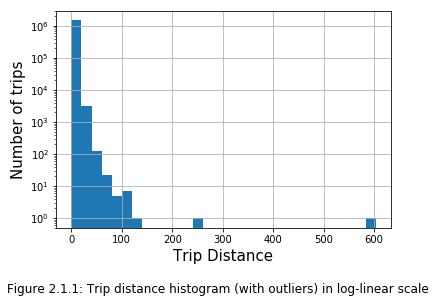

In [6]:
# plot Trip_distance histogram (with outliers)
raw_df["Trip_distance"].hist(bins=30)
plt.yscale('log')
plt.xlabel('Trip Distance', fontsize=15)
plt.ylabel('Number of trips', fontsize=15)
plt.figtext(0.5, -0.1, "Figure 2.1.1: Trip distance histogram (with outliers) in log-linear scale", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

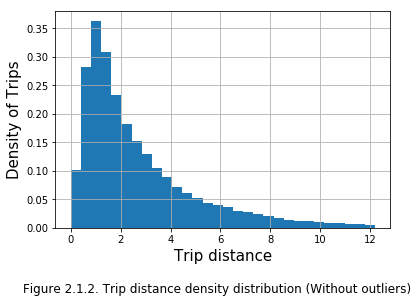

In [7]:
### define z_score
def z_score(df_series):
    df_median = np.mean(df_series)
    df_std = np.std(df_series)
    if not df_std:
        print("Error: standard deviation is zero, unable to compute z_score")
        exit(-1)
    return abs(df_series-df_median) / df_std

# filter outliers in 'Trip_distance' using z_score
filtered_trip_distance = raw_df[z_score(raw_df["Trip_distance"])<=3]["Trip_distance"]

# Plot normalized histogram, i.e., density distribution (without outliers)
filtered_trip_distance.hist(bins=30, density=True)
plt.xlabel("Trip distance", fontsize=15)
plt.ylabel("Density of Trips", fontsize=15)
plt.figtext(0.5, -0.1, "Figure 2.1.2. Trip distance density distribution (Without outliers)", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

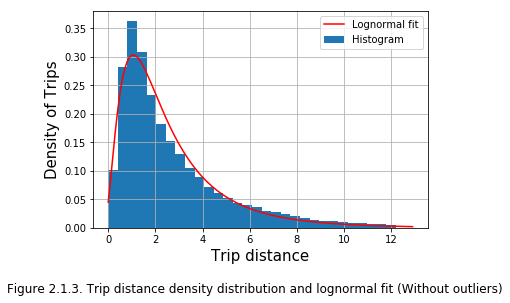

In [8]:
# Fit lognorm function to the distribution
shape, loc, scale = lognorm.fit(filtered_trip_distance)

# Plot normalized histogram, i.e., density distribution, and the fitted lognorm on the same plot
filtered_trip_distance.hist(bins=30, density=True)
fitted_dist = lognorm.pdf(np.arange(0, 13, 0.1), shape, loc, scale)
plt.plot(np.arange(0, 13, 0.1), fitted_dist, 'r')
plt.xlabel("Trip distance", fontsize=15)
plt.ylabel("Density of Trips", fontsize=15)
plt.legend(["Lognormal fit", "Histogram"])
plt.figtext(0.5, -0.1, "Figure 2.1.3. Trip distance density distribution and lognormal fit (Without outliers)", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

<a id='Section.2.2'></a>
### 2.2 Report any structure you find and any hypotheses you have about that structure

* **Structures in Trip distance density distribution**
    * From **Fig. 2.1.2**, we observe that the distribution shows a typical **right-skewed** structure after removing the outliers, i.e., the peak is off center and a long tail stretches away from the center. This skewness is due to the nature limit that trip distances have to be positive.
    * From **Fig. 2.1.2**, we observe that the distribution without outliers has a **log-normal** structure. This can be proved by fitting a log-normal function to distribution, see **Fig. 2.1.3**.
    
    
    
* **Hypotheses about the structure**

    The lognormal shaped, instead of Gaussian shaped, distribution of the Trip distance indicates that the trip    distance are not random. More specifically, the peak of the density appears at "Trip_distance" $\in [0.5,1.5]$. To understand this peak, we plot the Pickup and Dropoff locations for short trips, i.e., "Trip_distance" $\in [0.5,1.5]$ in **Fig. 2.2.1**, and for long trips, i.e., "Trip distance" > 2, in **Fig. 2.2.2**. As one can observe, the Pickup locations for both types of trips are concentrated in Manhattan, Brooklyn and Queens. However, the dropoff locations for short trips are also concentrated, while the Dropoff locations for long trips are scattered all over New York city. 
    
    **From the differece described above, we can make a hypotheis behind the highly skewed shape of Trip_distance distribution: the population density in Manhattan, Brooklyn and Queens are much higher than other regions, thus majority of people taking taxi inter and intra these three boroughs. As a result,the trip distances of are more concentrated to small values. The long tail of the Trip distance distribution are due to the trips from the city to the suburbs.**

    (A population density distribution of NYC in 2010 is attached to support our hypothesis. It shows that the outstanding population density in Manhattan, Brooklyn and Queen.)
    
(<a href='#outline'>Back to outline</a>)

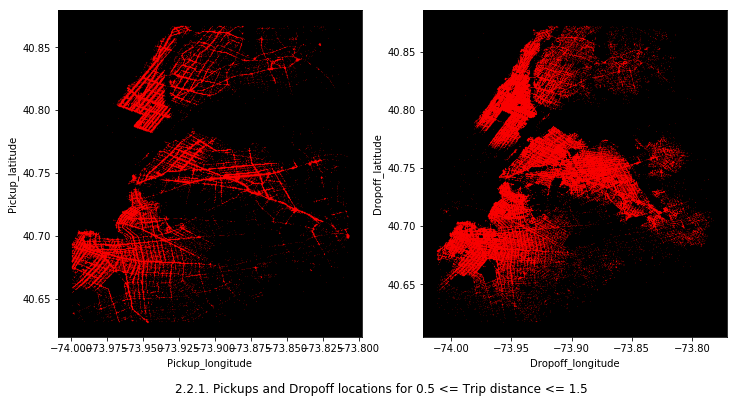

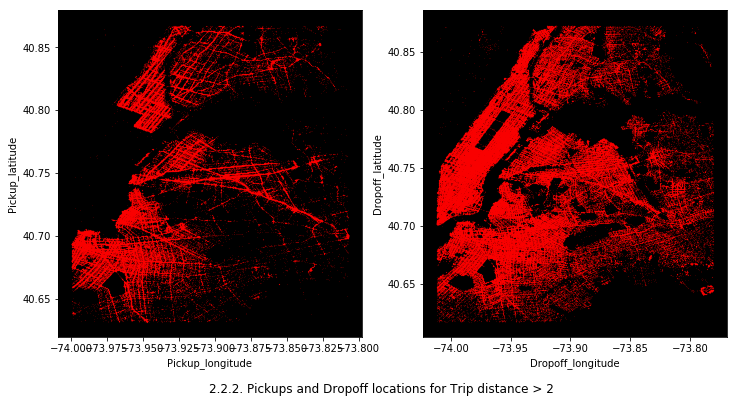

In [9]:
# define function to visualize Pickup and Dropoff locations
def plot_pickup_dropoff(df, title):
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

    df.plot(kind='scatter', x='Pickup_longitude', y='Pickup_latitude',
                    color='red', 
                    s=.01, alpha=.6, subplots=True, ax=ax1)
    ax1.set_facecolor('black')

    df.plot(kind='scatter', x='Dropoff_longitude', y='Dropoff_latitude',
                    color='red', 
                    s=.01, alpha=.6, subplots=True, ax=ax2)
    ax2.set_facecolor('black') 
    plt.figtext(0.5, -0.005, title, 
            wrap=True, horizontalalignment='center', fontsize=12)
    
# remove outliers in locations and Trip_distance
df = raw_df[(raw_df["Pickup_longitude"]>=np.quantile(raw_df["Pickup_longitude"], 0.01)) 
            & (raw_df["Pickup_longitude"]<=np.quantile(raw_df["Pickup_longitude"], 0.99)) 
            & (raw_df["Pickup_latitude"]>=np.quantile(raw_df["Pickup_latitude"], 0.01))
            & (raw_df["Pickup_latitude"]<=np.quantile(raw_df["Pickup_latitude"], 0.99))
            & (raw_df["Dropoff_longitude"]>=np.quantile(raw_df["Dropoff_longitude"], 0.01)) 
            & (raw_df["Dropoff_longitude"]<=np.quantile(raw_df["Dropoff_longitude"], 0.99)) 
            & (raw_df["Dropoff_latitude"]>=np.quantile(raw_df["Dropoff_latitude"], 0.01))
            & (raw_df["Dropoff_latitude"]<=np.quantile(raw_df["Dropoff_latitude"], 0.99))
            & (z_score(raw_df["Trip_distance"])<=3)]

# plot pickup and dropoff for short trips (Trip_distance<=1.5 & Trip_distance>=0.5)
plot_pickup_dropoff(df.query("Trip_distance<=1.5 & Trip_distance>=0.5"),
                    title="2.2.1. Pickups and Dropoff locations for 0.5 <= Trip distance <= 1.5")

# plot pickup and dropoff for long trips (Trip_distance > 2)
plot_pickup_dropoff(df.query("Trip_distance>2"), 
                    title="2.2.2. Pickups and Dropoff locations for Trip distance > 2")

* **NYC population density in different Boroughs** (Cite: http://www.undertheraedar.com/2012/01/population-density-in-new-york-city.html)

In [144]:
Image(url= "http://ajrae.staff.shef.ac.uk/img/nyc_popdens_2010.png")

<a id='Section.3'></a>
## 3. Question 3

<a id='Section.3.1'></a>
### 3.1 Report mean and median trip distance grouped by hour of day

* Observation: In **Fig. 3.1.1**, the distribution of mean/median trip distance across different hours of a day shows that
    * From 8:30pm to 9am on the second day, the mean trip distance of each hour (solid line) is larger than the mean trip distance (the dashed line) of a day. The median trip distance is similar too. 
    * Two peaks are observed through a day, i.e., 12 am and 5 am. However, the peak at 5am is much higher than the peak at 12 am.
* Hypothesis: To understand why the peak of mean/median trip distance appears around 5am, we plot the pickup and dropoff locations of trips at 5am (**Figure 3.1.1**) and 5 pm (**Figure 3.1.2**) for comparison. As one can observe, the distribution of trips are similar at both time, but the intensity differs. At 5am, the total number of trips is 15052, while the total number of trips at 5pm is 81514. Since the trip distance distribution is skewed to the right and has a peak around "Trip_distance" = 1.5 (<a href='#Section.2.2'>Section.2.2</a>), the median trip distance naturally shifts to the peak "Trip_distance" as the number of trip increases. 

(<a href='#outline'>Back to outline</a>)

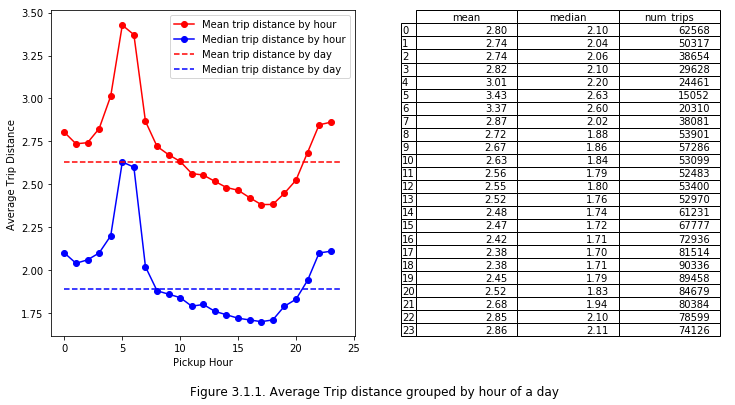

In [180]:
# extract pick up hour from "lpep_pickup_datetime"
df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
df['pickup_hour'] = df["lpep_pickup_datetime"].apply(lambda x: x.hour)

# group by hour and calculate mean and median
mean_trip_distance = df.groupby(by="pickup_hour")["Trip_distance"].mean()
median_trip_distance = df.groupby(by="pickup_hour")["Trip_distance"].median()
num_trips = df["pickup_hour"].value_counts()
df_table = pd.DataFrame(data={"mean": mean_trip_distance,
                              "median": median_trip_distance,
                              "num_trips": num_trips})

# calculate total mean and median
mean = df["Trip_distance"].mean()
median = df["Trip_distance"].median()

# plot mean, median 
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax1.plot(df_table["mean"],'r-o')
ax1.plot(df_table["median"], 'b-o')
xs = np.arange(0,24,0.1)
ax1.plot(xs,np.array([mean for i in xs]).reshape(xs.shape),'r--')
ax1.plot(xs,np.array([median for i in xs]).reshape(xs.shape),'b--')
ax1.legend(["Mean trip distance by hour", "Median trip distance by hour", 
             "Mean trip distance by day", "Median trip distance by day"])
ax1.set_xlabel("Pickup Hour")
ax1.set_ylabel("Average Trip Distance")
bbox=[0, 0, 1, 1]
df_table["mean"] = df_table['mean'].map('{:,.2f}'.format)
df_table["median"] = df_table["median"].map('{:,.2f}'.format)
ax2.axis('off')
ax2.table(cellText = df_table.values, rowLabels = df_table.index, bbox=bbox, colLabels=df_table.columns)
plt.figtext(0.5, -0.01, "Figure 3.1.1. Average Trip distance grouped by hour of a day", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

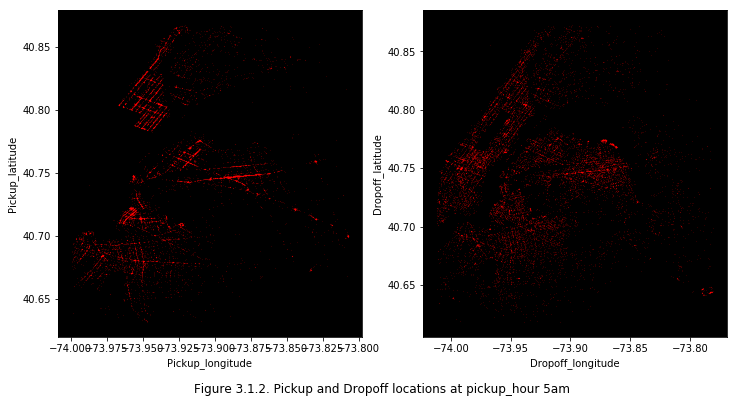

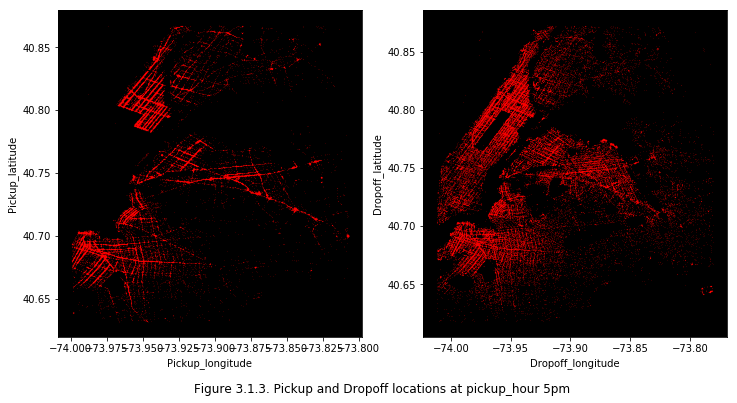

In [181]:
# Plot Pickup and dropoff locations when pickup_hour == 5
plot_pickup_dropoff(df.query("pickup_hour==5"), title="Figure 3.1.2. Pickup and Dropoff locations at pickup_hour 5am")

# Plot Pickup and dropoff locations when pickup_hour = 17
plot_pickup_dropoff(df.query("pickup_hour==17"),title="Figure 3.1.3. Pickup and Dropoff locations at pickup_hour 5pm")

<a id='Section.3.2'></a>
### 3.2 Identity trips that originate or terminate at one of the NYC area airports.

#### Methodology: 

   use the Pickup and Dropoff coordinates to derive whether or not a trip originates or terminates at one of the NYC area airports**. Here is why:

* **First, the RateCodeID seems not correctly recorded.** From the information posted on NYC Taxi & Limousine Commission (http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml#AirportTrips). Trips from or to NYC airports have specific "RateCodeID"**. For example,

    * **To & From LaGuardia Airport**: This is a metered fare. See Metered Fare information above.

    * **To/From JFK and any location in Manhattan**: "RateCodeID" = 2

    * **From JFK to other New York City destinations**: This is a metered fare. See Metered Fare information above.

    * **To Newark Airport**: "RateCodeID" = 3
    
    In <a href='#Figure.3.2'>**Figure.3.2**</a>, the Dropoff locations of the first 100 trips with "RateCodeID" == 3 are plotted on the map. If the records are correctly, the dropoff locations should be near Newark airport. However, as one can observe from the figure, some of the dropoff locations are far from Newark airport. 

* **Second, some of the trips from/to the airports, for example, any trips from or to LaGuardia airport, do not have "specific RateCodeID"**. It makes more sense to use the Pickup and Dropoff coordinates to derive whether or not a trip originates or terminates at one of the NYC area airports. To do this, a rectangle box of length=width=1km is defined near each airport, any trips with Pickup coordinates within the rectangular box near an airport are considered as originating from the airport. Similar to the the Dropoff coordiantes too.  


* <a href='#Section.3.2.1'> 3.2.1 How many transactions fit the criteria</a>
* <a href='#Section.3.2.2'> 3.2.2 The average fare</a>
* <a href='#Section.3.2.3'> 3.2.3 Other interesting characteristics of these trips</a>

(<a href='#outline'>Back to outline</a>)

In [11]:
# function calculate the distance (meter) between two coordinates
def distance_between_coordinates(lat1, lon1, lat2, lon2):
    """function calculate the distance (meter) between two coordinates

    :param lat1: latitude of coordinate 1
    :param lon1: longitude of coordinate 1
    :param lat2: latitude of coordinate 2
    :param lon2: longitude of coordinate 2
    """
    # approximate radius of earth in meter
    R = 6373.0e3
    # convert degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# function convert the distance box to coordinate box
def rectangle_bound_near_target(target_latitude, target_longitude, distance):
    lat = target_latitude
    long = target_longitude
    dist = 0
    increment = 0.001
    while dist < distance:
        lat += increment
        dist = distance_between_coordinates(lat, long, target_latitude, target_longitude)
    lat_range = abs(lat - target_latitude)

    lat = target_latitude
    dist = 0
    while dist < distance:
        long += increment
        dist = distance_between_coordinates(lat, long, target_latitude, target_longitude)
    long_range = abs(long - target_longitude)

    return lat_range, long_range

# define Airport class to avoid duplicate initialization
class Airport:
    
    def __init__(self, city_coordinate, airport_coordinates, near_airport_distance):
        """Initialize an airport object
        
        :param city_coordinate: city coordinate, (latitude, longitude)
        :param airport_coordinates: a dictionary contains the coordinates of airports, (latitude, longitude)
        :param near_airport_distance: the distance to the airport that considers to be near the airport
        """
        self.city_coordinate = city_coordinate
        self.airport_coordinates = airport_coordinates
        self.near_airport_distance = near_airport_distance
        self.near_airport_coordinate_bound = self.get_near_airport_coordinate_bound()
        
    def get_near_airport_coordinate_bound(self):
        """get the latitude and longitude bound near the airport
        
        :return near_airport_bound: a dictionary contains the coordinate bound near all airports
        """
        near_airport_coordinate_bound = {}
        for key, value in self.airport_coordinates.items():
            lat_range, long_range = rectangle_bound_near_target(value[0], value[1], self.near_airport_distance)
            near_airport_coordinate_bound[key] = (lat_range, long_range)
        return near_airport_coordinate_bound
    
    def get_airport_map_with_bound(self, tiles="Stamen Terrain", zoom_start=11):
        """create a folium map contains the airport and the bounds around it
        
        :param tiles: map visualization styling
        :param zoom_start: display the map in this zoom level
        :return airport_map: a folium map contains the airport marker and the bounds
        """
        airport_map = folium.Map(location=self.city_coordinate,
                                 tiles=tiles,
                                 zoom_start=zoom_start)
        
        # add airports and a circle region of radius 1km near the coordinates
        for key, value in self.airport_coordinates.items():
            folium.Marker(value, popup=key, icon=folium.Icon(color='green')).add_to(airport_map)
            rectangle_bound = []
            bound_range = self.near_airport_coordinate_bound[key]
            rectangle_bound.append((value[0] - bound_range[0], value[1] - bound_range[1]))
            rectangle_bound.append((value[0] - bound_range[0], value[1] + bound_range[1]))
            rectangle_bound.append((value[0] + bound_range[0], value[1] - bound_range[1]))
            rectangle_bound.append((value[0] + bound_range[0], value[1] + bound_range[1]))
            folium.Rectangle(rectangle_bound, popup="Airport pickup/Dropoff Region", color="red").add_to(airport_map)
            
        return airport_map
    
    def is_near_airport(self, airport_name, coordinate):
        airport_coordinate = self.airport_coordinates[airport_name]
        bound_range = self.near_airport_coordinate_bound[airport_name]
        if (coordinate[0] < airport_coordinate[0] - bound_range[0]) \
            or (coordinate[0] > airport_coordinate[0] + bound_range[0]) \
            or (coordinate[1] < airport_coordinate[1] - bound_range[1]) \
            or (coordinate[1] > airport_coordinate[1] + bound_range[1]):
                return False
        return True

In [12]:
# Create nyc_airport class using the coordinates of three major airports in NYC
nyc_coordinate = (40.7306, -73.9352)
airport_coordinates = {"JFK": (40.645727, -73.785991),
                    "NEWARK": (40.691831, -74.180015),
                    "LAGUA": (40.773225, -73.872253)}
nyc_airport = Airport(city_coordinate=nyc_coordinate,
                      airport_coordinates=airport_coordinates,
                      near_airport_distance=1000)

<a id='Figure.3.2'></a>
##### Figure 3.2. Plot the Dropoff locations of the top 10 trips with RateCodeID==3. The red markers denotes the dropoff locations of those trips and the green markers denotes the locations of the three airports.

In [13]:

df_rate03 = raw_df[raw_df["RateCodeID"]==3]
df_rate03["to_newark"] = df_rate03.apply(lambda x: nyc_airport.is_near_airport("NEWARK", 
                                                                               (x["Dropoff_latitude"], x["Dropoff_longitude"])),
                                         axis=1)
rate03_map = nyc_airport.get_airport_map_with_bound(tiles="CartoDB dark_matter", zoom_start=11)
for trip_id in range(10):
    dropoff_point = (df_rate03.iloc[trip_id]["Dropoff_latitude"], df_rate03.iloc[trip_id]["Dropoff_longitude"])
    folium.Marker(dropoff_point, icon=folium.Icon(color='red')).add_to(rate03_map)

# display the map
rate03_map

<a id='Section.3.2.1'></a>
#### 3.2.1 How many transactions fit the criteria

* **To derive whether or not a trip originates/terminates from/to the airports, we create 7 new columns to indicate if a trip is from/to an airport**:
    * "from_NEWARK": 1 if a trip is picked up near NEWARK airport
    * "to_NEWARK": 1 if a trip is dropped off near NEWARK airport
    * "from_JFK": 1 if a trip is picked up near JFK airport
    * "to_JFK": 1 if a trip is dropped off near JFK airport
    * "from_LAGUA": 1 if a trip is picked up near  LAGUARDIA airport
    * "to_LAGUA": 1 if a trip is dropped off near LAGUARDIA airport
    * "from_to_airport": 1 if a trip is picked_up or dropped off at any NYC airports

* **The total number of trips originating from or terminating at airports is 38847**. 

* **The trips originating from or terminating at airports are called airport trips for simplicity**.

(<a href='#outline'>Back to outline</a>)

In [14]:
df = raw_df.copy()

# derive "from_NEWARK", "to_NEWARK", "from_JFK", "to_JFK", "from_LAGUA", "to_LAGUA"
for airport_name, airport_coordinate in nyc_airport.airport_coordinates.items():
    airport_coordinate_bound = nyc_airport.near_airport_coordinate_bound[airport_name]
    # check if pickup from airport
    df["from_"+airport_name] = 0
    df_pickup = df.query("Pickup_latitude >= {0} &\
                     Pickup_latitude <= {1} &\
                     Pickup_longitude >= {2} &\
                     Pickup_longitude <= {3}".format(airport_coordinate[0] - airport_coordinate_bound[0],
                                                     airport_coordinate[0] + airport_coordinate_bound[0],
                                                     airport_coordinate[1] - airport_coordinate_bound[1],
                                                     airport_coordinate[1] + airport_coordinate_bound[1]))
    df.loc[df_pickup.index, "from_"+airport_name] = 1
    
    # check if dropoff at airport
    df["to_"+airport_name] = 0
    df_dropoff = df.query("Dropoff_latitude >= {0} &\
                     Dropoff_latitude <= {1} &\
                     Dropoff_longitude >= {2} &\
                     Dropoff_longitude <= {3}".format(airport_coordinate[0] - airport_coordinate_bound[0],
                                                     airport_coordinate[0] + airport_coordinate_bound[0],
                                                     airport_coordinate[1] - airport_coordinate_bound[1],
                                                     airport_coordinate[1] + airport_coordinate_bound[1]))
    df.loc[df_dropoff.index, "to_"+airport_name] = 1

# # derive "from_to_airport"
df["from_to_airport"] = df["from_JFK"] | df["to_JFK"] \
                        | df["from_NEWARK"] | df["to_NEWARK"] \
                        | df["from_LAGUA"] | df["to_LAGUA"]
df[df["from_to_airport"]==1].shape

(38847, 28)

##### In **Table.3.2.1**, we show the respective number of trips from / to each airport.

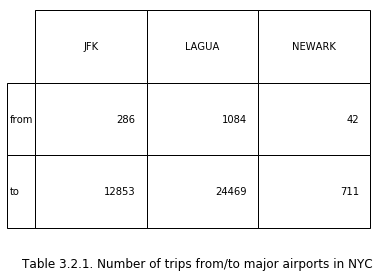

In [15]:
# plot number of trips from/to each airport
df_table = pd.DataFrame(data={"NEWARK": [df[df["from_NEWARK"]==1].shape[0], df[df["to_NEWARK"]==1].shape[0]],
                              "JFK": [df[df["from_JFK"]==1].shape[0], df[df["to_JFK"]==1].shape[0]],
                              "LAGUA": [df[df["from_LAGUA"]==1].shape[0], df[df["to_LAGUA"]==1].shape[0]]},
                       index=["from", "to"])
f, ax = plt.subplots(nrows=1, ncols=1)
ax.axis("off")
bbox = [0, 0, 1, 1]
ax.table(cellText = df_table.values, rowLabels = df_table.index, bbox=bbox, colLabels=df_table.columns)
plt.figtext(0.5, -0.01, "Table 3.2.1. Number of trips from/to major airports in NYC", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

#### Visualize the Pickup locations of trips originating from airports and the Dropoff locations of trips terminating from airports to validate that the trips are correctly indentified. 

As one can observe from the map, only trips originating and terminating at the airports are selected. It is worth noticing that neither the dropoff locations of trips originating from airports nor the pickup locations of trips terminating at airports are ploted in the figure. 

In [16]:
tmp_map = nyc_airport.get_airport_map_with_bound()
# Plot pickup locations of trips originating from the airports
df_from_airport = df.query("from_NEWARK==1 or from_JFK==1 or from_LAGUA==1")
pickup_matrix = df_from_airport[['Pickup_latitude', 'Pickup_longitude']].as_matrix()
tmp_map.add_children(plugins.HeatMap(pickup_matrix, radius=15))
# Plot dropoff locations of trips terminating at the airports
df_to_airport = df.query("to_NEWARK==1 or to_JFK==1 or to_LAGUA==1")
dropoff_matrix = df_to_airport[['Dropoff_latitude', 'Dropoff_longitude']].as_matrix()
tmp_map.add_children(plugins.HeatMap(dropoff_matrix, name="Dropoff", radius=15))
tmp_map

<a id='Section.3.2.2'></a>
#### 3.2.2 The average fare

* **The average fare of airport trips is $33.92**


(<a href='#outline'>Back to outline</a>)


In [17]:
df[df["from_to_airport"]==1]["Total_amount"].mean()

33.91849512190092

<a id='Section.3.2.3'></a>
#### 3.2.3 Other interesting characteristics of airport trips.

In this section, we use violin plot (https://datavizcatalogue.com/methods/violin_plot.html), which is a combination of boxplot and density plot, to visualize the distribution of different variables, including fare-related variables, distance-related variables and time related variables, for both airport trips and non airport trips. By comparing the distributions for these two types of trips, we are able to find interesting characteristics of airport trips.

* <a href='#Section.3.2.3.A'>A. Interesting characteristic related to Distance</a>

* <a href='#Section.3.2.3.B'>B. Interesting characteristic related to Fare</a>:

* <a href='#Section.3.2.3.C'>C. Interesting characteristic related to Time</a>

(<a href='#outline'>Back to outline</a>)
    

In [18]:
# define helper functions for distribution plot
def sns_box_plot(x_var, y_var, df, ax):
    quantile_limit = [np.quantile(df[y_var], 0.01), np.quantile(df[y_var], 0.99)]
    sns.boxplot(x=x_var, y=y_var, data=df, ax=ax)
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_ylim(quantile_limit)
    
def sns_violin_plot(x_var, y_var, df, ax, grid_on=False):
    quantile_limit = [np.quantile(df[y_var], 0.01), np.quantile(df[y_var], 0.99)]
    df_tmp = df[(df[y_var]<= quantile_limit[1]) & (df[y_var] >= quantile_limit[0])]
    sns.violinplot(x=x_var, y=y_var, data=df_tmp, ax=ax)
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.grid(b=grid_on)
    
def sns_dist_plot(x_var, y_var, df, ax):
    quantile_limit = [np.quantile(df[y_var], 0.01), np.quantile(df[y_var], 0.99)]
    df_tmp = df[(df[y_var]<= quantile_limit[1]) & (df[y_var] >= quantile_limit[0])]
    legend = []
    for i in df_tmp[x_var].unique():
        legend.append(x_var+"="+str(i))
        sns.distplot(df_tmp[df_tmp[x_var]==i][y_var], bins=30, ax=ax)
    ax.legend(legend)
    ax.set_xlabel(y_var)
    ax.set_ylabel("density")

<a id='Section.3.2.3.A'></a>
##### A. characteristc related to distance

Here, we separate the distributions of "Trip_distance" for trips grouped by from/to airport or not. From **Fig.3.2.3.1**, one can observe that 
* 1) The median of "Trip_distance" for airport trips is larger than that of the non airport trips. This makes sense since airports, like JFK, are far from the main business/residential area, e.g., Manhattan, Queens, Brooklyn.  
* 2) The density of "Trip_distance" of non airport trips show a log-normal shape and the density peak appears at "Trip_distance" = 1 mile. However, the density of "Trip_distance" of airport trips show multiple peaks at 3 miles, 7.5 miles, 11 miles, etc. One hypothesis would be that these three peaks correspond to the average distance from the three airports to the main business/residential area. 


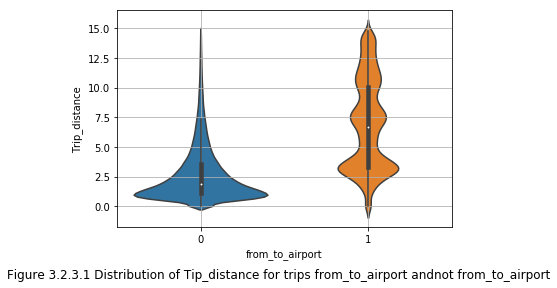

In [138]:
f, ax = plt.subplots(1, 1)
sns_violin_plot("from_to_airport", "Trip_distance", df, ax, grid_on=True)
plt.figtext(0.5, -0.05, "Figure 3.2.3.1 Distribution of Tip_distance for trips from_to_airport and\
not from_to_airport", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

<a id='Section.3.2.3.B'></a>
##### B. Interesting characteristic related to Fare
Here, we separate the distributions of variables related to fare for trips grouped by from/to airport or not. Only variables with significant differences are ploted here, i.e., "Fare_amount", "Tip_amount", "Total_amount".

* "Fare_amount": From **Fig.3.2.3.2**, one can observe that 
    * The median "fare_amount" of airport trips ($\$22$) is larger than that of the non-airport trips ($\$10$). This can be explained by the typically longer distance of airport trips. 
    * Several peaks are observed in the density plot of fare amount for airport trips, for example, fare_amount = $\$12, \$23, \$30, \$40$. However, for non airport trips, only one peak at fare amount = $\$6$ is observed.
        
* "Total_amount": From **Fig.3.2.3.2**, one can observe that 
    * Similar to "fare_amout", the median "Total_amount" of airport trips ($\$27$) is larger than that of the non-airport trips ($\$11$). This can be explained by the typically longer distance of airport trips. 
    * Several peaks are observed in the density plot of fare amount for airport trips, for example, fare_amount = $\$14$, $\$38$. However, for non airport trips, only one peak at fare amount = $\$8$ is observed.

* "Tip_amount": From **Fig.3.2.3.3**, which is the distribution of "Tip_amount" for trips with non-zero tips, one can observe that
    * The median tip amount for airport trips ($\$ 4.5$) is larger than that of non airport trips ($\$2$)
    * The tip amount of both airport trips and non airport trips show density peaks at integer amounts, which makes sense because people tend to give integer tips. 

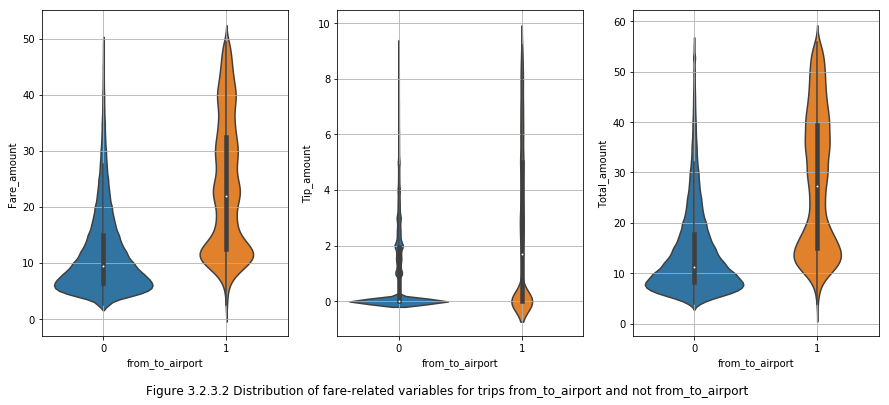

In [139]:
var_list = ["Fare_amount", "Tip_amount", "Total_amount"]
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))
for i, var in enumerate(var_list):
    sns_violin_plot("from_to_airport", var, df, axes[i], grid_on=True)

plt.figtext(0.5, -0.01, "Figure 3.2.3.2 Distribution of fare-related variables for trips from_to_airport and not from_to_airport", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

* Plot distribution of Tip amount for trips with Tip_amount > 0

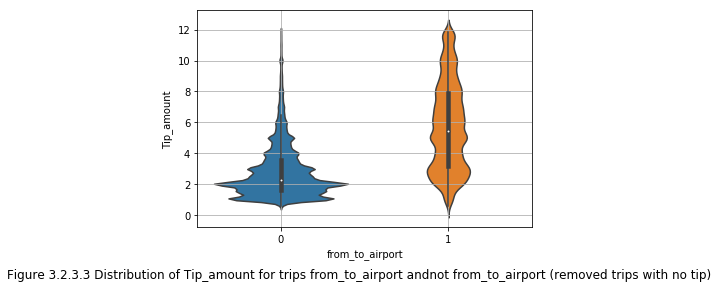

In [140]:
f, ax = plt.subplots(1,1)
sns_violin_plot("from_to_airport", "Tip_amount", df[df["Tip_amount"]>0], ax, grid_on=True)
plt.figtext(0.5, -0.05, "Figure 3.2.3.3 Distribution of Tip_amount for trips from_to_airport and\
not from_to_airport (removed trips with no tip)", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

<a id='Section.3.2.3.C'></a>
##### C. characteristics related to time
Here, we separate the distributions of variables related to time for trips grouped by from/to airport or not. These variables include 
* "pickup_hour": the hour of pickup. From **Fig.3.2.3.4**, one can observe that:
    * The density peak of non airport trips appears at 8:00 (go to work), 18:00 (leave work), 0:00 (probably when the night life ends), and the trough appears at 5:00 (too early). However, the peak of airport trips appears at 15:00 and the trough appears at 0:00 (people dislike traveling at night)
 
* "time_duration": the time duration between Pickup and Dropoff. From **Fig.3.2.3.4**, one can observe that:
    * The density plot of time duration for non airport trips and airport trips are similar, except that the peak of airport trips appears at larger time duration (10 mins) than that of non airport trips (6min). 
    * The median time duration of airport trips (19 mins) is larger than that of non airport trips (10min). This can also be explained by the typically longer distances of the airport trips.  

In [106]:
def to_min(datetime):
    return ((datetime.month*30 + datetime.day)*24 + datetime.hour)*60 + datetime.minute + datetime.second/60

df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
df["Lpep_dropoff_datetime"] = pd.to_datetime(df["Lpep_dropoff_datetime"])
df["pickup_hour"] = df["lpep_pickup_datetime"].apply(lambda x: x.hour)
df["time_duration"] = (df["Lpep_dropoff_datetime"].apply(lambda x: to_min(x)) - 
                       df["lpep_pickup_datetime"].apply(lambda x: to_min(x)))

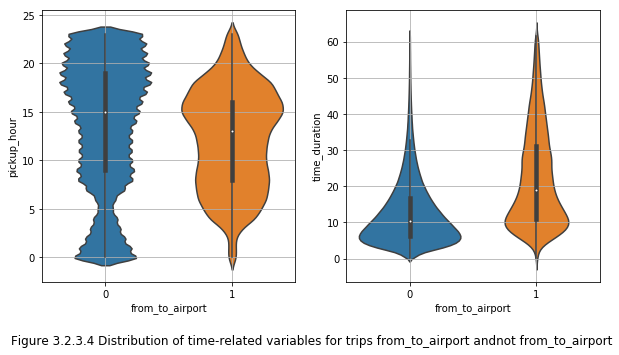

In [134]:
var_list = ["pickup_hour", "time_duration"]
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i, var in enumerate(var_list):
    sns_violin_plot("from_to_airport", var, df, axes[i], grid_on=True)
plt.figtext(0.5, -0.05, "Figure 3.2.3.4 Distribution of time-related variables for trips from_to_airport and\
not from_to_airport", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

<a id='Section.4'></a>
## 4. Question 4

In this section, we build a regression model to predict the tip percentage, which is the Tip_amount as a percentage of the "Total_amount". In <a href='#Section.4.1'>Section.4.1</a>, we remove all data points with Total_amount<=0 or Tip_amout <0, and then derive the "tip_percentage" variable. In <a href='#Section.4.2'>Section.4.2</a>, we present the whole process of building the predictive model, including:

* <a href='#Section.4.2.1'>4.2.1. Data cleaning and preprocessing</a>
* <a href='#Section.4.2.2'>4.2.2. Baseline model and evaluation</a>
* <a href='#Section.4.2.3'>4.2.3. Feature engineering</a>
* <a href='#Section.4.2.4'>4.2.4. Final model and evaluation</a>



(<a href='#outline'>Back to outline</a>)

Before we move on, let's standardlize the column names to ease our life, this includes:
* Remove spaces
* Convert all letter to lower cases

In [135]:
def rename_columns(df):
    """rename column names, the processing is inplace
    
    :param df: dataframe to be processed
    :return None
    """
    print("Start renaming columns ...")
    new_columns = [column.strip().lower() for column in df.columns]
    df.columns = new_columns
    print("End renaming columns.")

In [136]:
df = raw_df.copy()
rename_columns(df)
df.shape

Start renaming columns ...
End renaming columns.


(1494926, 21)

<a id='Section.4.1'></a>
### 4.1 Build a derived variable for tip as a percentage of the total fare 

Before deriving the tip percentage, we need to address the incorrect values related to fares in the original dataset.
According to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml, the criteria include:
* All fare-related values cannot be negative, take the absolute value if there are any.
* "fare_amount" cannot be less than $\$2.50$ after taking the absolute value. Remove the data point if the fare amount is less than $\$2.5$
    
After addressing the incorrect records, the tip_percentage is derived as tip_percentage = tip_amount / total_amount. A few characteristics of the derived tip_percentage (after droppping outliers) can be drawn from Figure.4.1.1:
* min = 0, median = 0, 75 percentile = 16.7%, max=98.9%
* 60% of data has zero tip_percentage
* The peaks of the density plot appear around tip_percentage = 0%, 17%, 20% and 23%

(<a href='#outline'>Back to outline</a>)

In [137]:
def derive_tip_percentage(df):
    """derive tip_percentage variable, the processing is inplace
    
    :param df: dataframe to be processed
    :return None
    """
    print("Start deriving tip percentage...")
    nrows = df.shape[0]
    # take absolute value for fare related variables
    fare_related_vars = ["fare_amount", "tip_amount", "extra", "mta_tax", 
                         "tolls_amount", "improvement_surcharge", "total_amount"]
    for fare_related_var in fare_related_vars:
        df[fare_related_var] = df[fare_related_var].abs()
    # fare_amount cannot be less than $2.5
    invalid_index = df[df["fare_amount"]<2.5].index
    df.drop(labels=invalid_index, axis=0, inplace=True)
    print("Data points with fare_amount < $2.5 are dropped ({0:.4f}% of total data)".
          format(len(invalid_index) / nrows * 100))
    # derive tip_percentage = Tip_amount / Fare_amount
    df["tip_percentage"] = (df["tip_amount"] / df["total_amount"]) * 100
    print("{0:.2f}% data has zero tip_percentage".format((df[df["tip_percentage"]==0].shape[0] / df.shape[0])*100))
    print("End deriving tip percentage.")

In [138]:
derive_tip_percentage(df)
df.tip_percentage.describe()

Start deriving tip percentage...
Data points with fare_amount < $2.5 are dropped (0.3383% of total data)
59.55% data has zero tip_percentage
End deriving tip percentage.


count    1.489869e+06
mean     6.646277e+00
std      8.820730e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e+01
max      9.891197e+01
Name: tip_percentage, dtype: float64

* Visualize the distribution of derived tip_percentage (only look at the area between 1 and 99 percentile)

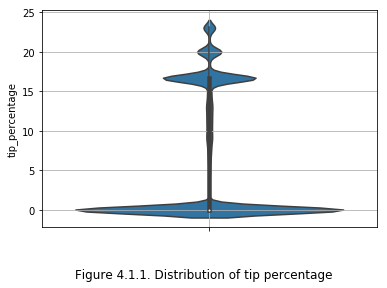

In [463]:
f, ax = plt.subplots(1,1)
sns_violin_plot(x_var=None, y_var="tip_percentage", df=df, ax=ax, grid_on=True)
plt.figtext(0.5, -0.05, "Figure 4.1.1. Distribution of tip percentage", 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

<a id='Section.4.2'></a>
### 4.2 Build a predictive model for tip as a percentage of the total fare and evaluate the model.


(<a href='#outline'>Back to outline</a>)

<a id='Section.4.2.1'></a>
#### 4.2.1 Data cleaning and preprocessing

* Process NA values: In the data we have, only "ehail_fee" and "trip_type" have NA values, which are handled in the following way depending on the distributions and meanings of the data fields:
    * "ehail_fee": 100% data are NA values, thus the column is dropped
    * "trip_type": according to the data dictionary, the Trip can only be 1 (Street-hail) or 2 (Dispatch), thus we fill the NA as the mode. 


* Transform non-numeric data to numeric: There are some non-numerical columns in the dataset we have. For example, "lpep_pickup_datetime", "lpep_dropoff_datetime", "store_and_fwd_flag". Some models, for example, LR, cannot handle these non-numerical objects. Thus, we need to transform these data fields according to their specific properties. In particular,
    * Time related objects ("lpep_pickup_datetime", "lpep_dropoff_datetime"): derive "week", "day", "hour", "minute", "time_duration" (time duration between dropoff time and pickup time), "weekday" (from 0(Monday) to 6(Sunday)). And then drop "lepep_pickup_datetime" and "lpep_dropoff_datetime"
    * Store_and_fwd_flag: label encode all the values.
    
* More cleaning on continuous variables, including "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "trip_distance", "time_duration", "passenger_count", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "tip_percentage". By simply looking at the boxplot of each continuous variables, we are able to find the outliers easily, and take actions based on our understanding of the data. In particular:
    * coordinate-related columns, including "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude": 
        * drop data points with values == 0. These data are apparently missing values, but they only take about 0.22% of the original dataset, this it is totally acceptable to drop them. One can also impute them as the median/mean coordinates.
    * trip duration related columns, including time_duration and trip_distance:
        * derive speed for each trip using trip_distance / time_duration, [unit]=miles/hour
        * drop data with unlikely large speed (larger than 150 miles/hour). 
        * if time_duration or trip_duration is zero, imput the speed as the average speed of all the other trips.
        * if time_duration == 0, but trip_distance != 0, impute time_duration = trip_distance / speed (using proper units)
        * if trip_distance == 0, but time_duration != 0, impute the trip_distance = time_duration * speed (using proper units)
        * if time_duration == 0 and trip_distance == 0, drop the data point.
        
    * passenger_count:
        * impute passenger_count==0 using the mode
    * Fare-related columns: these columns have already been handled when deriving the tip_percentage
* More cleaning on categorical variables, including 'hour', 'weekday', 'week', 'vendorid', 'store_and_fwd_flag', 'minute', 'day', 'trip_type', 'payment_type', 'ratecodeid'.
    * From the histogram of all the categorical columns, no additional special data cleaning needs to be done for now

    
    

In [139]:
# define a function to process NA in a dataframe 
def process_na(df, method_dict={}):
    """ Process NA values in dataframes using methods defined in method_dict
    
    :param df: the dataframe to be processed, the processing will be handled in place, i.e., no need to return new df
    :param method_dict: the method dictionary defining the method to handle NA for each column. If the method is not
                        defined for a column, it will be set to be "drop_na" by default, i.e., all data points with NA
                        values in this column are dropped.
    :return: None
    """
    print("Start processing NA, data shape = {0}...".format(df.shape))
    original_rows = df.shape[0]
    
    for column in df.columns:
        n_rows = df.shape[0]
        # get method for column
        if column in method_dict:
            method = method_dict[column]
        else:
            method = "drop_na"
        # 
        try:
            if method == "drop_col":
                df.drop(columns=column, inplace=True)
            elif method == "drop_na":
                df.dropna(axis='index', subset=[column], inplace=True)
                new_n_rows = df.shape[0]
                dropped_frac = (new_n_rows - n_rows) / original_rows
                if dropped_frac >= 0.01:
                    print("Warning: Dropped {0}% data points using method '{1}' for column '{2}'".
                         format(dropped_frac*100, method, column))
            elif method == "mode":
                column_mode = df[column].mode().tolist()[0]
                df[column].fillna(column_mode, inplace=True)
            elif method == "median":
                column_median == df[column].median()
                df[column].fillna(column_median, inplace=True)
            else:
                print("Error: undefined fillna method '{0}' for column '{1}'. Exiting...".format(method, column))
                raise SystemExit
        except Exception as e:
            print("Error: During processing NA values, the error '{0}' occured. Exiting...".format(e.args))
            raise SystemExit
    print("End processing NA, new data shape = {0}".format(df.shape))
    
def to_min(datetime):
    """convert a datetime to unit in minute"""
    return ((datetime.month*30 + datetime.day)*24 + datetime.hour)*60 + datetime.minute + datetime.second/60

def transform_objects_to_numerical(df):
    """transform columns with dtype=object to numerical columns
    
    :param df: dataframe to be processed
    :return: None, all the processings are inplace
    """
    print("Start transforming object columns to numeric columns..., data_shape = {0}".format(df.shape))
    # time related variables
    df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])
    df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])
    df["weekday"] = df["lpep_pickup_datetime"].apply(lambda x: x.weekday())
    df["week"] = df["lpep_pickup_datetime"].apply(lambda x: x.week)
    df["day"] = df["lpep_pickup_datetime"].apply(lambda x: x.day)
    df["hour"] = df["lpep_pickup_datetime"].apply(lambda x: x.hour)
    df["minute"] = df["lpep_pickup_datetime"].apply(lambda x: x.minute)
    df["time_duration"] = df["lpep_dropoff_datetime"].apply(lambda x: to_min(x)) - \
                          df["lpep_pickup_datetime"].apply(lambda x: to_min(x))
    df.drop(labels=["lpep_pickup_datetime", "lpep_dropoff_datetime"], axis=1, inplace=True)
        
    # label encode "Store_and_fwd_flag"
    le = LabelEncoder()
    df["store_and_fwd_flag"] = le.fit_transform(df["store_and_fwd_flag"])
    
    # final check if all columns are numeric dtype
    for column in df.columns:
        if not pd.api.types.is_numeric_dtype(df[column]):
            print("Error: Column '{0}' is not numeric after processing. Exiting ...")
            exit(-1)
    print("End transforming object columns to numeric columns, data shape = {0}".format(df.shape))
    
def clean_continuous_cols(df):
    # clean coordinate related cols
    print("Start cleaning continuous columns ...")
    nrows = df.shape[0]
    drop_index = df[(df["pickup_latitude"]==0) | (df["dropoff_latitude"]==0) |\
            (df["pickup_longitude"]==0) | (df["dropoff_longitude"]==0)].index
    df.drop(labels=drop_index, axis=0, inplace=True) # drop data inplace
    
    # derive speed
    valid_index = df[(df["trip_distance"]>0) & (df["time_duration"]>0)].index
    df.loc[valid_index, "speed"] = df.loc[valid_index, "trip_distance"] / df.loc[valid_index, "time_duration"] * 60
    # drop over speed trips
    over_speed_index = df[df.speed>180].index
    df.drop(labels=over_speed_index, axis=0, inplace=True)
    print("droped over speed datapoints ({0:.4f}% of data points)".format(len(over_speed_index)/nrows*100))
    # impute NA speed 
    df["speed"].fillna(np.mean(df["speed"]), inplace=True)
    # drop trips with both trip_distance==0 and time_duration==0
    zero_dist_time_index = df[(df["trip_distance"]==0) & (df["time_duration"]==0)].index
    df.drop(labels=zero_dist_time_index, axis=0, inplace=True)
    print("droped data points with both time_duration==0 and trip_distance==0 ({0:.4f}% of data points)".
          format(len(zero_dist_time_index)/nrows*100))
    # impute trip_distance = speed * time_duration if trip_distance == 0
    zero_trip_distance_index = df[df["trip_distance"]==0].index
    df.loc[zero_trip_distance_index, "trip_distance"] = df.loc[zero_trip_distance_index, "speed"] *\
                                                        df.loc[zero_trip_distance_index, "time_duration"] / 60
    print("imputed zero trip_distance using time_duration * speed ({0:.4f}% of total data points)".
          format(len(zero_trip_distance_index)/nrows*100))
    
    # impute time_duration = trip_distance / speed if time_duration == 0
    zero_time_duration_index = df[df["time_duration"]==0].index
    df.loc[zero_time_duration_index, "time_duration"] = df.loc[zero_time_duration_index, "trip_distance"] /\
                                                        df.loc[zero_time_duration_index, "speed"] * 60
    print("imputed zero time_duration using trip_distance / speed ({0:.4f}% of total data points)".
          format(len(zero_time_duration_index)/nrows*100))
    
    # impute zero passenger_count using the mode
    zero_passenger_index = df[df["passenger_count"]==0].index
    passenger_mode = df["passenger_count"].mode()[0]
    df.loc[zero_passenger_index, "passenger_count"] = passenger_mode
    print("imputed zero passenger_count mode = {0} ({1:.4f}% of total data points)".
          format(passenger_mode, len(zero_passenger_index)/nrows*100))
    print("End cleaning continuous columns.")
    
def preprocessing_data(df):
    rename_columns(df)
    derive_tip_percentage(df)
    process_na(df, {"ehail_fee":"drop_col", "trip_type":"mode"})
    transform_objects_to_numerical(df)
    clean_continuous_cols(df)

In [144]:
df = raw_df.copy()
print(df.shape)
preprocessing_data(df)
print(df.shape)

(1494926, 21)
Start renaming columns ...
End renaming columns.
Start deriving tip percentage...
Data points with fare_amount < $2.5 are dropped (0.3383% of total data)
59.55% data has zero tip_percentage
End deriving tip percentage.
Start processing NA, data shape = (1489869, 22)...
End processing NA, new data shape = (1489869, 21)
Start transforming object columns to numeric columns..., data_shape = (1489869, 21)
End transforming object columns to numeric columns, data shape = (1489869, 25)
Start cleaning continuous columns ...
droped over speed datapoints (0.1485% of data points)
droped data points with both time_duration==0 and trip_distance==0 (0.0047% of data points)
imputed zero trip_distance using time_duration * speed (1.2086% of total data points)
imputed zero time_duration using trip_distance / speed (0.0076% of total data points)
imputed zero passenger_count mode = 1 (0.0161% of total data points)
End cleaning continuous columns.
(1484375, 26)


In [145]:
con_vars = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "trip_distance", "time_duration"
           , "speed", "passenger_count", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", 
           "improvement_surcharge", "total_amount", "tip_percentage"]
cat_vars = list(set(df.columns) - set(con_vars))

<a id='Section.4.2.2'></a>
#### 4.2.2 Baseline model and evaluation

In [151]:
import datetime
current_time = str(datetime.datetime.now().time())
print("current_time = {0}".format(current_time))
df.to_csv("raw_data/df_"+current_time+".csv", index=None)

current_time = 01:11:51.911271


In [46]:
data_file = "../raw_data/df_01:11:51.911271.csv"
print("Reading data from {0}".format(data_file))
df = pd.read_csv("../raw_data/df_01:11:51.911271.csv")

Reading data from ../raw_data/df_01:11:51.911271.csv


In [60]:
from data_handler import generate_X_Y
from model_pipeline import *

### A classification model

In [ ]:
X, Y, feature_names = generate_X_Y(df=df,
                                   sample_frac=0.01,
                                   target_cols="tip_percentage",
                                   drop_cols=["tip_amount", "total_amount"],
                                   is_classification=True,
                                   class_boundary=0,
                                   savefolder="results/",
                                   random_state=42)

clf = xgb.XGBClassifier()

xgb_search_params = {
    'min_child_weight': np.arange(1, 6, 2),
    'max_depth': np.arange(3, 10, 2),
    'gamma': np.arange(0, 0.5, 0.1),
    'subsample': np.arange(0.2, 1.0, 0.2),
    'colsample_bytree': np.arange(0.2, 1, 0.2),
    'learning_rate': np.arange(0.01, 0.1, 0.02),
    'n_estimators': np.arange(600, 1000, 200)
}

cv_clf = clf_RandomSearchCV_pipeline(clf, X, Y, feature_names, test_size=0.2, 
                            search_params=xgb_search_params, n_jobs=8, n_iter=100)
                            

### A regression model

****************************************Data report****************************************
X.shape = (14844, 23)
Y.shape = (14844,)
Predictors: Index(['vendorid', 'store_and_fwd_flag', 'ratecodeid', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'improvement_surcharge', 'payment_type', 'trip_type',
       'weekday', 'week', 'day', 'hour', 'minute', 'time_duration', 'speed'],
      dtype='object')
Target: tip_percentage
****************************************start training****************************************
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed:   20.4s finished



 Time taken: 0 hours 0 minutes and 21.73 seconds.
****************************************Save Grid search result****************************************
****************************************making predictions****************************************
****************************************model performance on test data****************************************
****************************************regression report****************************************
r2_score : 0.6195008455927842
mean_square_error : 29.114702704447208
explained_variance_score : 0.6196887008356243
****************************************plot feature importance****************************************


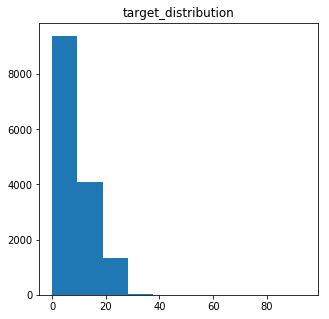

/home/jyli/projects/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


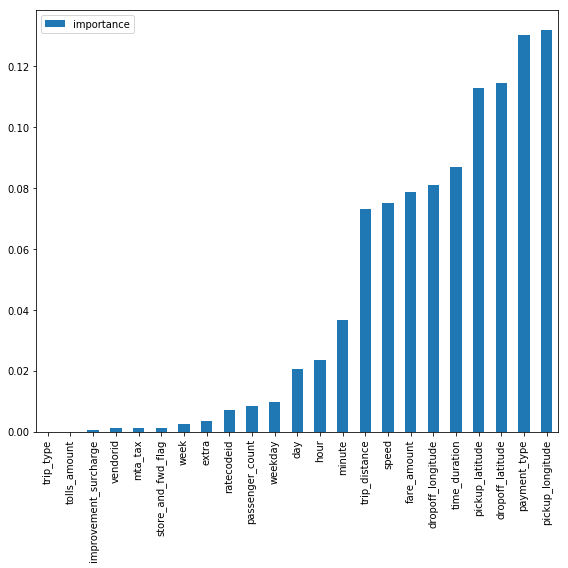

In [59]:
from model_pipeline import reg_RandomSearchCV_pipeline

X, Y, feature_names = generate_X_Y(df=df,
                                   sample_frac=0.01,
                                   target_cols="tip_percentage",
                                   drop_cols=["tip_amount", "total_amount"],
                                   is_classification=False,
                                   savefolder="results/",
                                   random_state=42)

reg = xgb.XGBRegressor()

xgb_search_params = {
    'min_child_weight': np.arange(1, 6, 2),
    'max_depth': np.arange(3, 10, 2),
    'gamma': np.arange(0, 0.5, 0.1),
    'subsample': np.arange(0.2, 1.0, 0.2),
    'colsample_bytree': np.arange(0.2, 1, 0.2),
    'learning_rate': np.arange(0.01, 0.1, 0.02),
    'n_estimators': np.arange(50, 300, 50)
}

cv_reg = reg_RandomSearchCV_pipeline(reg, X, Y, feature_names, test_size=0.2, 
                            search_params=xgb_search_params, n_jobs=8, n_iter=25)
                            

In [37]:
import multiprocessing
multiprocessing.cpu_count()

8

<a id='Section.4.2.3'></a>
#### 4.2.3 Feature engineering

<a id='Section.4.2.4'></a>
#### 4.2.4 Final model and evaluation

In [148]:
df_sample = raw_df.sample(frac=0.01)
pickup_matrix = df_sample[['Pickup_latitude', 'Pickup_longitude']].as_matrix()
tmp_map = nyc_airport.get_airport_map_with_bound()
tmp_map.add_children(plugins.HeatMap(pickup_matrix, radius=15))
tmp_map

In [149]:
df_sample["lpep_pickup_datetime"] = pd.to_datetime(df_sample["lpep_pickup_datetime"])
df_sample["hour"] = df_sample["lpep_pickup_datetime"].apply(lambda x: x.hour)
# Create weight column, using date
heat_df = df_sample[["Pickup_latitude", "Pickup_longitude", "hour"]]
# List comprehension to make out list of lists
heat_data = [[[row['Pickup_latitude'],row['Pickup_longitude']] for index, row in heat_df[heat_df['hour'] == i].iterrows()] for i in range(24)]

In [150]:
animated_map = nyc_airport.get_airport_map_with_bound()
# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(animated_map)
# Display the map
animated_map

In [78]:
raw_df["Pickup_to_jfk"] = raw_df.apply(lambda x: distance_between_coordinates(x["Pickup_latitude"],
                                                                              x["Pickup_longitude"],
                                                                              airport_locations["JFK"][0],
                                                                              airport_locations["JFK"][1]),
                                      axis=1)
raw_df["Dropoff_to_jfk"] = raw_df.apply(lambda x: distance_between_coordinates(x["Dropoff_latitude"],
                                                                              x["Dropoff_longitude"],
                                                                              airport_locations["JFK"][0],
                                                                              airport_locations["JFK"][1]),
                                      axis=1)
raw_df["Pickup_to_newark"] = raw_df.apply(lambda x: distance_between_coordinates(x["Pickup_latitude"],
                                                                              x["Pickup_longitude"],
                                                                              airport_locations["NEWARK"][0],
                                                                              airport_locations["NEWARK"][1]),
                                      axis=1)
raw_df["Dropoff_to_newark"] = raw_df.apply(lambda x: distance_between_coordinates(x["Dropoff_latitude"],
                                                                              x["Dropoff_longitude"],
                                                                              airport_locations["NEWARK"][0],
                                                                              airport_locations["NEWARK"][1]),
                                      axis=1)

In [81]:
raw_df.to_csv(train_data_loader.data_path, index=None)

In [6]:
raw_df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type '],
      dtype='object')

### 3.2 Trips originated or teminated at NYC airports

From "Data Dictionary" (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf), I thought "RateCodeID" can help to filter out all trips originated or terminated at one of the NYC area airports. But the information in this "Data Dictionary" is poorly explained, so I looked up more information posted on NYC Taxi & Limousine Commission (http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml#AirportTrips).

**To & From LaGuardia Airport**: This is a metered fare. See Metered Fare information above.

**To/From JFK and any location in Manhattan**: "RateCodeID" = 2

**From JFK to other New York City destinations**: This is a metered fare. See Metered Fare information above.

**To Newark Airport**: "RateCodeID" = 3

Thus, only using "RateCodeID" to determine if a trip originated or terminated from NYC area airports is not enough because we are likely to miss some trips, for example, trips from JFK to other NYC destinations other than Manhattan. We need to define function to identify is a trip originated or terminated from one of the NYC area airports, i.e., JFK, Newark, and Laguardia.

**How this function work**: 
   #### 1. if "RateCodeID" == 2 or 3, return True;
   #### 2. if "RateCodeID" != 2 or 3, check if the Dropoff or Pickup location is within the geographical area of any NYC airports.

**Geographical area of an airport**:
Here a simple model is employed: draw a rectangle around each airports and extract the longitude and latitude information of the four verticles of the rectangle. Any trip that originate or terminate within this retangle are considered as related to this airport.

In [10]:
def from_to_airport(trip):
    pickup_long = trip['Pickup_longitude']
    dropoff_long = trip['Dropoff_longitude']
    pickup_lat  = trip['Pickup_latitude']
    dropoff_lat = trip['Dropoff_latitude']
    JFK_loc = [-73.79,-73.756,40.63,40.65]
    Newark_loc = [-74.19, -74.15,40.67, 40.70]
    Lagua_loc = [-73.89,-73.855,40.77,40.78]
    loc=[JFK_loc,Newark_loc,Lagua_loc]
    result = False
    if trip["RateCodeID"] in [2,3]:
        result=True
    else:
        for location in loc:
            if ((location[0]<=pickup_long<=location[1] and location[2]<=pickup_lat<=location[3]) or (location[0]<=dropoff_long<=location[1] and location[2]<=dropoff_lat<=location[3])):
                result = True
    return result

In [11]:
# only take trips that are related to airport and store the data in a new dataframe
# this function takes about a minute
df_airport = df[df.apply(lambda x: from_to_airport(x), axis=1)]

In [12]:
# save data
print "Number of trips originated or terminated from NYC airports = %d" % df_airport.shape[0]
df_airport.head(5)

Number of trips originated or terminated from NYC airports = 32667


VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
26          2  2015-09-01 00:00:35   2015-09-01 00:08:31                  N   
31          2  2015-09-01 00:07:12   2015-09-01 00:07:27                  N   
146         2  2015-09-01 00:21:08   2015-09-01 00:21:12                  N   
253         2  2015-09-01 00:08:33   2015-09-01 00:23:17                  N   
584         2  2015-09-01 00:00:39   2015-09-01 00:15:26                  N   

     RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
26            1        -73.844879        40.755024         -73.872223   
31            2        -73.844269        40.755165         -73.844650   
146           2        -73.930214        40.677612         -73.930214   
253           1        -73.877457        40.737480         -73.780273   
584           1        -73.844994        40.719166         -73.783691   

     Dropoff_latitude  Passenger_count  Trip_distance  Fare_amount  Extra  \
26          40.773991                1           2.92         10.5    0.5   
31          40.755058                1           0.00         52.0    0.0   
146         40.677673                1           0.00         52.0    0.0   
253         40.645378                5          10.54         29.0    0.5   
584         40.644211                1           7.63         22.5    0.5   

     MTA_tax  Tip_amount  Tolls_amount  Ehail_fee  improvement_surcharge  \
26       0.5        2.36             0        NaN                    0.3   
31       0.5        0.00             0        NaN                    0.3   
146      0.5        0.00             0        NaN                    0.3   
253      0.5        0.00             0        NaN                    0.3   
584      0.5        4.76             0        NaN                    0.3   

     Total_amount  Payment_type  Trip_type   hour_of_day  
26          14.16             1           1            0  
31          52.80             2           1            0  
146         52.80             2           1            0  
253         30.30             2           1            0  
584         28.56             1           1            0

#### What if we only use "RateCodeID"?

In [13]:
df_rateCodeID = df[df["RateCodeID"]==2]+df[df["RateCodeID"]==3]
print "Number of trips originated or terminated from NYC airports = %d (only use 'RateCodeID as filter')" % df_rateCodeID.shape[0]

Number of trips originated or terminated from NYC airports = 5552 (only use 'RateCodeID as filter')


#### Average fare

In [14]:
fare_amount = df_airport["Fare_amount"].mean()
total_amount = df_airport["Total_amount"].mean()
print "average fare_amount (The time-and-distance fare calculated by the meter) = $%f\n\
average total_amount (The total amount charged to passengers. Does not include cash tips) = $%f" % (fare_amount, total_amount)

average fare_amount (The time-and-distance fare calculated by the meter) = $31.139074
average total_amount (The total amount charged to passengers. Does not include cash tips) = $37.288052


#### Hour of day histogram

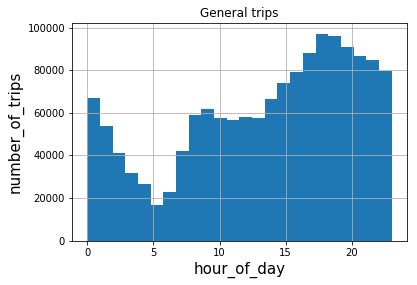

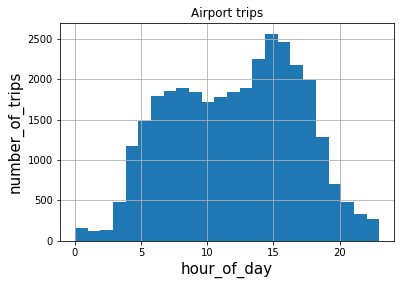

save figure to trip_histogram_hourofDay.png 


In [15]:
plt.gcf().clear()
df.hist(column="hour_of_day",bins=24)
plt.xlabel('hour_of_day', fontsize=15)
plt.ylabel('number_of_trips', fontsize=15)
plt.title('General trips')
df_airport.hist(column="hour_of_day",bins=24)
plt.xlabel('hour_of_day', fontsize=15)
plt.ylabel('number_of_trips', fontsize=15)
plt.title('Airport trips')
plt.show()
# save figure
figure_path = 'trip_histogram_hourofDay.png'
print "save figure to %s " % figure_path
plt.savefig(figure_path,dpi = 600)

**Other comments related to airport trip analysis**
1. If only use "RateCodeID" to filter out airport trips, we get 5552 entries, while using a geographical filter we can get 32667 entries. This reminds us again that we should always be careful with data features and sources to avoid improper understanding of feature handles. 
2. The simple/naive geographical airport trip filter I defined could introduce some errors because of trips that originated or terminated near airport. To improve the accuracy, we can use some complex shapes rather than retangles to represent the airport area. 

### 2. Exploratory data analysis (EDA)

In this section, an extensive exploratory data analysis is done to find interesting patterns in the data. These analysis also enlighten the feature engineering process to build a better predictive model. The section is organized as follows:

* **2.1 Univariate data analysis**
* **2.2 Multivariate data analysis**
* **2.3 Basic data cleaning**


### 4.1 derive a variable "Tip_percentage" for tip as a percentage of total fare. 

**0.1) From the preview of dataframe, "Ehail_fee" contains a lot of "NAN" value, we need to take a closer look at it**

In [16]:
df["Ehail_fee"].describe()

count     0
mean    NaN
std     NaN
min     NaN
25%     NaN
50%     NaN
75%     NaN
max     NaN
Name: Ehail_fee, dtype: float64

* Drop "Ehail_fee" since most values are "NAN"

In [17]:
df = df.drop('Ehail_fee',axis=1)

**0.2) Filter out unrealistic data**
* Filter out "Fare_amount" <= 0
* Filter out "Extra" < 0
* Filter out "MTA_tax" < 0
* Filter out "improvement_surface" < 0 **

In [18]:
def fare_filter(x):
    if (x["Fare_amount"]>0 and x["Extra"]>=0 and x["MTA_tax"]>=0 and x["improvement_surcharge"]>=0):
        return True
    else:
        return False

In [19]:
df = df[df.apply(lambda x: fare_filter(x), axis=1)]
df.shape

(1488040, 21)

**1) Derive "Total_fare"**
* We define "Total_fare" as "Fare_amount"+"Extra"+"MTA_tax"+"Tolls_amount" +"improvement_surcharge"

In [20]:
df["Total_fare"] = df.Fare_amount + df.Extra + df.MTA_tax + df.Tolls_amount + df.improvement_surcharge

**2) Derive new variable "Tip_percentage" = "Tip_amount" / "Total_amount"**

In [21]:
df["Tip_percentage"] = df.Tip_amount*100/df.Total_fare

In [22]:
# "Tip_percentage" for all the trips
print "-"*40+"For all trips:"+"-"*40
print df['Tip_percentage'].describe()

----------------------------------------For all trips:----------------------------------------
count    1488040.000000
mean           8.586525
std           33.261272
min            0.000000
25%            0.000000
50%            0.000000
75%           20.000000
max        15000.000000
Name: Tip_percentage, dtype: float64


**There are outlier values in Tip_percentage, for example, max = 15000. To get a better understanding of the distribution of Tip_percentage, we need to remove the outlier**
* Outlier: if abs(x-median(Tip_percentage)) > 3 * std(Tip_percentage), then x is a outlier

In [23]:
median_tipping = np.median(df.Tip_percentage)
std_tipping = np.std(df.Tip_percentage)
df = df[abs(df.Tip_percentage-median_tipping)<= 3*std_tipping]
print df.Tip_percentage.describe()

count    1485954.000000
mean           7.986929
std           10.626385
min            0.000000
25%            0.000000
50%            0.000000
75%           20.000000
max           99.733840
Name: Tip_percentage, dtype: float64


**Look at the histogram of Tippping percentage**

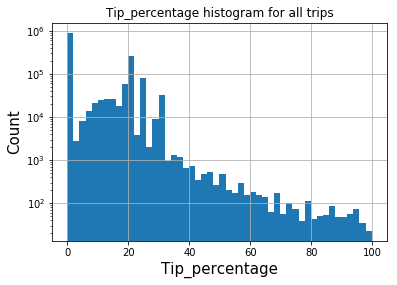

In [24]:
plt.gcf().clear()
df.Tip_percentage.hist(bins=50)
plt.yscale('log')
plt.xlabel('Tip_percentage', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Tip_percentage histogram for all trips")
plt.show()

**There are some bumps along the Tip_percentage histrogram, to figure out where there bumps comes from, we plot the histogram of Tip_amount below**

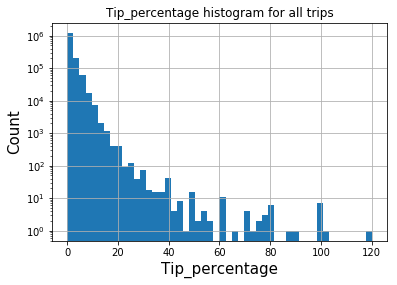

In [25]:
plt.gcf().clear()
df.Tip_amount.hist(bins=50)
plt.yscale('log')
plt.xlabel('Tip_percentage', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Tip_percentage histogram for all trips")
plt.show()

The information about the "Tip_percentage shows that":
* More than 50% of all riders do not pay any tip
* Among all the people who paid tips, the average / median tipping percentage is 20%, which agrees well with the tipping guide published on **The New York times** http://www.nytimes.com/fodors/top/features/travel/destinations/unitedstates/newyork/newyorkcity/fdrs_feat_111_10.html?n=Top%2FFeatures%2FTravel%2FDestinations%2FUnited+States%2FNew+York%2FNew+York+City, i,e, 15%-20% for taxi drivers and waiters.
* Tip_percentage histogram shows a log-normal pattern with some bumps that corresponds to interger Tip_amount like, 20, 30, 40, 60, 80, 100, etc. It means that people are likely to round up their tipping. 


**We create a new dataframe for all trips with Tip_percentage > 0**

In [26]:
df_withTip = df[df.Tip_percentage>0]
print df_withTip.shape

(600480, 23)


### Save the dataframe we processed above

In [27]:
df.to_csv("data/cleaned_df_1.csv")

### 4.2 Build a regression model to predict "Tip_percentage"

### Data cleaning and Feature section 

**Read the dataFrame we processed above: data/cleaned_df_1.csv**

In [28]:
df = pd.read_csv("data/cleaned_df_1.csv")
print df.keys()
df.head(5)

Index([u'Unnamed: 0', u'VendorID', u'lpep_pickup_datetime',
       u'Lpep_dropoff_datetime', u'Store_and_fwd_flag', u'RateCodeID',
       u'Pickup_longitude', u'Pickup_latitude', u'Dropoff_longitude',
       u'Dropoff_latitude', u'Passenger_count', u'Trip_distance',
       u'Fare_amount', u'Extra', u'MTA_tax', u'Tip_amount', u'Tolls_amount',
       u'improvement_surcharge', u'Total_amount', u'Payment_type',
       u'Trip_type ', u'hour_of_day', u'Total_fare', u'Tip_percentage'],
      dtype='object')


Unnamed: 0  VendorID lpep_pickup_datetime Lpep_dropoff_datetime  \
0           0         2  2015-09-01 00:02:34   2015-09-01 00:02:38   
1           1         2  2015-09-01 00:04:20   2015-09-01 00:04:24   
2           2         2  2015-09-01 00:01:50   2015-09-01 00:04:24   
3           3         2  2015-09-01 00:02:36   2015-09-01 00:06:42   
4           4         2  2015-09-01 00:00:14   2015-09-01 00:04:20   

  Store_and_fwd_flag  RateCodeID  Pickup_longitude  Pickup_latitude  \
0                  N           5        -73.979485        40.684956   
1                  N           5        -74.010796        40.912216   
2                  N           1        -73.921410        40.766708   
3                  N           1        -73.921387        40.766678   
4                  N           1        -73.955482        40.714046   

   Dropoff_longitude  Dropoff_latitude  Passenger_count  Trip_distance  \
0         -73.979431         40.685020                1           0.00   
1         -74.010780         40.912212                1           0.00   
2         -73.914413         40.764687                1           0.59   
3         -73.931427         40.771584                1           0.74   
4         -73.944412         40.714729                1           0.61   

   Fare_amount  Extra  MTA_tax  Tip_amount  Tolls_amount  \
0          7.8    0.0      0.0        1.95             0   
1         45.0    0.0      0.0        0.00             0   
2          4.0    0.5      0.5        0.50             0   
3          5.0    0.5      0.5        0.00             0   
4          5.0    0.5      0.5        0.00             0   

   improvement_surcharge  Total_amount  Payment_type  Trip_type   hour_of_day  \
0                    0.0          9.75             1           2            0   
1                    0.0         45.00             1           2            0   
2                    0.3          5.80             1           1            0   
3                    0.3          6.30             2           1            0   
4                    0.3          6.30             2           1            0   

   Total_fare  Tip_percentage  
0         7.8       25.000000  
1        45.0        0.000000  
2         5.3        9.433962  
3         6.3        0.000000  
4         6.3        0.000000

There is an extra space in key = "Trip_type ", replace it with "Trip_type"

In [29]:
df = df.rename(columns={"Trip_type ": "Trip_type"})

### Process categorical Features:
* Unnamed:0 (ignore)
* VendorID
* Store_and_fwd_flag
* RateCodeID
* Payment_type
* Trip_type

In [30]:
print "-"*20 + "VendorID" + "-"*20
print df.groupby("VendorID")["Tip_percentage"].size()
print "-"*20 + "Store_and_fwd_flag" + "-"*20
print df.groupby("Store_and_fwd_flag")["Tip_percentage"].size()
print "-"*20 + "RateCodeID" + "-"*20
print df.groupby("RateCodeID")["Tip_percentage"].size()
print "-"*20 + "Payment_type" + "-"*20
print df.groupby("Payment_type")["Tip_percentage"].size()
print "-"*20 + "Trip_type" + "-"*20
print df.groupby("Trip_type")["Tip_percentage"].size()

--------------------VendorID--------------------
VendorID
1     321243
2    1164711
dtype: int64
--------------------Store_and_fwd_flag--------------------
Store_and_fwd_flag
N    1477404
Y       8550
dtype: int64
--------------------RateCodeID--------------------
RateCodeID
1     1449775
2        4294
3        1089
4         908
5       29852
6          32
99          4
dtype: int64
--------------------Payment_type--------------------
Payment_type
1    698712
2    779791
3      3932
4      3447
5        72
dtype: int64
--------------------Trip_type--------------------
Trip_type
1    1456561
2      29389
dtype: int64


**1) According to Data Dictionary, RateCodeID cannot be 99, and there are only 4 of them, so it is safe to drop these data**

**2) Store_and_fwd_flag values are str, we need to transform them into int**

In [31]:
df = df[df["RateCodeID"]!=99]

In [32]:
df["Store_and_fwd_flag2"] = (df["Store_and_fwd_flag"]=="Y")*1
df = df.drop("Store_and_fwd_flag",axis=1)
df = df.rename(columns={"Store_and_fwd_flag2":"Store_and_fwd_flag"})
print df.groupby("Store_and_fwd_flag")["Tip_percentage"].size()

Store_and_fwd_flag
0    1477404
1       8546
dtype: int64


###  Process other features:
* lpep_pickup_datetime
* Lpep_dropoff_datetime
* Pickup_longitude
* Pickup_latitude
* Dropoff_longitude
* Dropoff_latitude
* Passenger_count 
* Trip_distance 
* Fare_amount 
* Extra
* MTA_tax, 
* Tolls_amount
* improvement_surcharge',
* Total_amount
* Total_fare
* hour_of_day

**1) Derive "pickup_day", "pickup_hour","pickup_minute", "dropoff_day", "dropoff_hour","dropoff_minute" from all time related features including "lpep_pickup_datetime", "Lpep_dropoff_datetime". Use these derived features instead of the old time features whose types are strings**

In [33]:
def extract_day(x):
    time = x.split(' ')
    return int(time[0][8:10])
def extract_hour(x):
    time = x.split(' ')
    return int(time[1][:2])
def extract_minute(x):
    time = x.split(' ')
    return int(time[1][3:5])

def derive_time(dataframe):
    dataframe["pickup_day"] = dataframe['lpep_pickup_datetime'].apply(extract_day)
    dataframe["pickup_hour"] = dataframe['lpep_pickup_datetime'].apply(extract_hour)
    dataframe["pickup_minute"] = dataframe['lpep_pickup_datetime'].apply(extract_minute)
    dataframe["dropoff_day"] = dataframe['Lpep_dropoff_datetime'].apply(extract_day)
    dataframe["dropoff_hour"] = dataframe['Lpep_dropoff_datetime'].apply(extract_hour)
    dataframe["dropoff_minute"] = dataframe['Lpep_dropoff_datetime'].apply(extract_minute)
    dataframe["time_duration"] = (dataframe.dropoff_day*24*60 + dataframe.dropoff_hour*60+dataframe.dropoff_minute) - (dataframe.pickup_day*24*60 + dataframe.pickup_hour*60+dataframe.pickup_minute)
    return dataframe

In [34]:
df = derive_time(df)

In [35]:
median_duration = np.median(df.time_duration)
std_duration = np.std(df.time_duration)
df = df[abs(df.time_duration-median_duration)<= 3*std_duration]

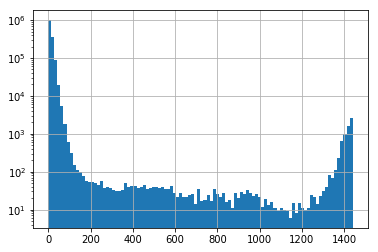

In [36]:
df.time_duration.hist(bins=100)
plt.yscale("log")
plt.show()

**2) Keep all location and distance related features including "Pickup_longtitude", "Pickup_latitude", "Dropoff_longitude", "Dropoff_latitude", "Trip_distance" whose types are float**

**3) Ignore all fare related features including "Fare_amount", "Extra", "MTA_tax", "Tolls_amount", "improvement_surcharge", and only Use "Total_fare" feature we derived in previous analysis **

* Total_fare = Fare_amount + Extra + MTA_tax + Tolls_amount + improvement_surcharge

### Feature selection conclusion

The predictors we use are:

**1) categorical features (converted into int)**

* VendorID
* RateCodeID
* Payment_type
* Trip_type
* Store_and_fwd_flag

**2) other feautures **

* pickup_day
* pickup_hour
* dropoff_hour
* time_duration
* Pickup_longitude
* Pickup_latitude
* Dropoff_longitude
* Dropoff_latitude
* Passenger_count
* Trip_distance
* Total_fare

In [ ]:
df = df[["VendorID",
            "RateCodeID",
             "Payment_type",
             "Trip_type",
             "Store_and_fwd_flag",
             "pickup_day",
             "pickup_hour",
             "dropoff_hour",
             "time_duration",
             "Pickup_longitude",
             "Pickup_latitude",
             "Dropoff_longitude",
             "Dropoff_latitude",
             "Passenger_count",
             "Trip_distance",
             "Total_fare",
             "Tip_percentage"]]

### we define a function to summary up all the data cleaning and feature selection we have done above.

In [39]:
dataPath = 'data/green_tripdata_2015-09.csv'
if os.path.isfile(dataPath):
    df = pd.read_csv(dataPath)
else:
    print "%s is not found, try to get the data from https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv\
           and put it in data/ under the same directory of this notebook "

In [40]:
def fare_filter(x):
    if (x["Fare_amount"]>0 and x["Extra"]>=0 and x["MTA_tax"]>=0 and x["improvement_surcharge"]>=0):
        return True
    else:
        return False
def extract_day(x):
    time = x.split(' ')
    return int(time[0][8:10])
def extract_hour(x):
    time = x.split(' ')
    return int(time[1][:2])
def extract_minute(x):
    time = x.split(' ')
    return int(time[1][3:5])
def derive_time(dataframe):
    dataframe["pickup_day"] = dataframe['lpep_pickup_datetime'].apply(extract_day)
    dataframe["pickup_hour"] = dataframe['lpep_pickup_datetime'].apply(extract_hour)
    dataframe["pickup_minute"] = dataframe['lpep_pickup_datetime'].apply(extract_minute)
    dataframe["dropoff_day"] = dataframe['Lpep_dropoff_datetime'].apply(extract_day)
    dataframe["dropoff_hour"] = dataframe['Lpep_dropoff_datetime'].apply(extract_hour)
    dataframe["dropoff_minute"] = dataframe['Lpep_dropoff_datetime'].apply(extract_minute)
    dataframe["time_duration"] = (dataframe.dropoff_day*24*60 + dataframe.dropoff_hour*60+dataframe.dropoff_minute) - (dataframe.pickup_day*24*60 + dataframe.pickup_hour*60+dataframe.pickup_minute)
    median_timeduration = np.median(dataframe.time_duration)
    std_timeduration = np.std(dataframe.time_duration)
    dataframe = dataframe[abs(dataframe.time_duration-median_timeduration)<= 3*std_timeduration]
    return dataframe

In [41]:
def clean_dataframe(df):
    # Filter all invalid fare
    print "-"*40 +"Drop all invalid fee"+"-"*40
    cleaned_df = df[df.apply(lambda x: fare_filter(x), axis=1)]
    cleaned_df["Total_fare"] = cleaned_df.Fare_amount + cleaned_df.Extra + cleaned_df.MTA_tax + cleaned_df.Tolls_amount + cleaned_df.improvement_surcharge
    cleaned_df["Tip_percentage"] = cleaned_df.Tip_amount*100/cleaned_df.Total_fare
    median_tipping = np.median(cleaned_df.Tip_percentage)
    std_tipping = np.std(cleaned_df.Tip_percentage)
    cleaned_df = cleaned_df[abs(cleaned_df.Tip_percentage-median_tipping)<= 3*std_tipping]
    # rename "Trip_type "
    print "-"*40 +"Rename 'Trip_type ' to 'Trip_type'"+"-"*40
    cleaned_df = cleaned_df.rename(columns={"Trip_type ": "Trip_type"})
    # Remove "RateCodeID = 99"
    print "-"*40 +"Drop 'RateCodeID' == 99"+"-"*40
    cleaned_df = cleaned_df[cleaned_df["RateCodeID"]!=99]
    # Convert "Store_and_fwd_flags values from string to int"
    print "-"*40 +"Convert 'Store_and_fwd_flags' values from string to int"+"-"*40
    cleaned_df["Store_and_fwd_flag2"] = (cleaned_df["Store_and_fwd_flag"]=="Y")*1
    cleaned_df = cleaned_df.drop("Store_and_fwd_flag",axis=1)
    cleaned_df = cleaned_df.rename(columns={"Store_and_fwd_flag2":"Store_and_fwd_flag"})
    # Derive time related features
    print "-"*40 +"Derive time related features"+"-"*40
    cleaned_df = derive_time(cleaned_df)
    # Drop useless features
    print "-"*40 +"Drop useless features"+"-"*40
    cleaned_df = cleaned_df[["VendorID",
                             "RateCodeID",
                             "Payment_type",
                             "Trip_type",
                             "Store_and_fwd_flag",
                             "pickup_day",
                             "pickup_hour",
                             "dropoff_hour",
                             "time_duration",
                             "Pickup_longitude",
                             "Pickup_latitude",
                             "Dropoff_longitude",
                             "Dropoff_latitude",
                             "Passenger_count",
                             "Trip_distance",
                             "Total_fare",
                             "Tip_percentage"]]
    return cleaned_df

In [42]:
cleaned_df = clean_dataframe(df)

----------------------------------------Drop all invalid fee----------------------------------------
----------------------------------------Rename 'Trip_type ' to 'Trip_type'----------------------------------------
----------------------------------------Drop 'RateCodeID' == 99----------------------------------------
----------------------------------------Convert 'Store_and_fwd_flags' values from string to int----------------------------------------
----------------------------------------Derive time related features----------------------------------------
----------------------------------------Drop useless features----------------------------------------


In [43]:
cleaned_df.to_csv("data/df_clean_final.csv")

### Train Random Forest regressor to Predict Tip_percentage

1) Read in the cleaned data set with all the predictors and target we need to use

In [50]:
df_allData = pd.read_csv("data/df_clean_final.csv")

2) only take a portional of the data to train and test model because of the computation cost and time constraints

In [51]:
df = df_allData.sample(100000)

3) define predictors (X) and target (Y)

In [52]:
target = df.Tip_percentage
predictors = df.drop(["Tip_percentage","Unnamed: 0"],axis=1)

In [ ]:
print "-"*40 + "Target" + "-"*40
print np.size(target)
print "-"*40 + "Predictors" + "-"*40
print predictors.keys()
print np.size(predictors["Total_fare"])

----------------------------------------Target----------------------------------------
100000
----------------------------------------Predictors----------------------------------------
Index([u'VendorID', u'RateCodeID', u'Payment_type', u'Trip_type',
       u'Store_and_fwd_flag', u'pickup_day', u'pickup_hour', u'dropoff_hour',
       u'time_duration', u'Pickup_longitude', u'Pickup_latitude',
       u'Dropoff_longitude', u'Dropoff_latitude', u'Passenger_count',
       u'Trip_distance', u'Total_fare'],
      dtype='object')
100000


4) Import necessary libraries

In [53]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

5) randomly split our dataset to training set: test set = 8:2

In [54]:
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, 
                                                                                target, 
                                                                                test_size=0.2, 
                                                                                random_state=60637)

6) Standardization of the data set using "Transformer API" in Scikit_learn

In [56]:
scaler = preprocessing.StandardScaler().fit(predictors_train)

In [57]:
predictors_train_scaled = scaler.transform(predictors_train)
predictors_test_scaled = scaler.transform(predictors_test)

7) Tune model using cross-validation pipeline
* This model optimization part refers to a very nice tutorial I have been using for a lone time, originally it is from here https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn#step-3)

In [58]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))

In [59]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [60]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
# Fit and tune model
clf.fit(predictors_train, target_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_depth': [None, 5, 3, 1], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

8) predict "Tip_percentage" on test set and compute the errors.

In [61]:
pred = clf.predict(predictors_test)
print r2_score(target_test, pred)
print mean_squared_error(target_test, pred)

0.651526043546
39.67517745


9) dump the trained model to local

In [313]:
joblib.dump(clf, 'my_randomforest.pkl')

['my_randomforest.pkl']

**Prediction error of from the model I trained are not satisfying, and this is mainly because I only used 10% of the dataset for train the RF model due to time constraint. If I were given more time, I would try the following things:**
* Use spark to parallelize the code and train the model over more data. I have a lot of experience using Spark in my Machine learning class, but I do not the access to a cluster environment after the class, so I cannot use Spark for this code challenge.
* From the Data dictionary, we know that Cash Tips are not included. And it is reasonable to assume, if the rider paid cash for the trip, they are unlikely to pay tips using credit cards. So, building a classifier to predict if a rider will pay Tip (in this case, it means tip in credit cards) before predicting tip_percentage could be useful.

### Question 5: Option A

### 5.1 Derive a variable representing the average_speed over a trip
* average_speed = Tip_distance / time_duration

**Read in saved cleaned data, remove data with zero time_duration or zero Trip_distance**

In [3]:
df = pd.read_csv("data/df_clean_final.csv")
df=df[df.time_duration!=0]
df=df[df.Trip_distance!=0]

**compute average_speed**

In [4]:
df["average_speed"] = df.Trip_distance/df.time_duration * 60

In [5]:
df.average_speed.describe()

count    1461179.000000
mean          13.182287
std           11.387530
min            0.000417
25%            9.400000
50%           11.900000
75%           15.200000
max         4170.000000
Name: average_speed, dtype: float64

**Remove outlier**

In [6]:
median = np.median(df.average_speed)
std = np.std(df.average_speed)
df = df[abs(df.average_speed-median)<=3*std]

In [7]:
df.average_speed.describe()

count    1459476.000000
mean          13.008276
std            5.749069
min            0.000417
25%            9.388235
50%           11.900000
75%           15.189474
max           46.061538
Name: average_speed, dtype: float64

**Plot the distribution of average_speed over trip**

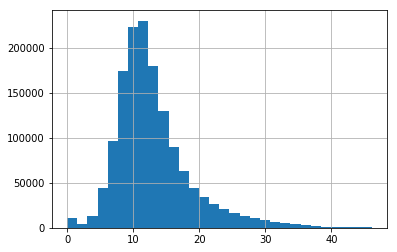

In [8]:
plt.gcf().clear()
df.average_speed.hist(bins=30)
plt.show()

### 5.2 Average trip speeds in all weeks of September

**Derive week_of_month for all data**

In [9]:
# 2015 September 1 is Tuesday, week 1
def week_of_september_2015(day):
    return int(day // 7 + 1)

**Average speed of all trips for each month**

In [10]:
df["week_of_month"] = df.apply(lambda x: week_of_september_2015(x['pickup_day']),axis=1)
meanspeed_by_week = df.groupby("week_of_month")["average_speed"].mean()

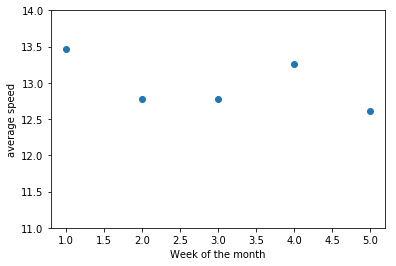

In [11]:
plt.gcf().clear()
plt.plot(range(1,6),meanspeed_by_week,"o")
plt.ylim([11,14])
plt.xlabel("Week of the month")
plt.ylabel("average speed")
plt.show()

** Perform Hypothesis test to determine if the trip speed distribution are materially the same in all weeks of September**

**Null hypothesis: speed distribution between two weeks are the same.**
**Significance level alpha = 0.05**

* From the test, we see that p_value for testing week2 and week3 is larger than 0.05, thus we failed to reject the Null hypothesis, i.e., speed distribution between these two weeks are the same with high confidence.

* For all the other pairs, we can reject the Null hypothesis, i.e, speed distributions are different. 


In [12]:
test = []
for i in range(5):
    for j in range(5):
        if j!=i:
            weeki_average_speed = df[df["week_of_month"]==i+1]["average_speed"]
            weekj_average_speed = df[df["week_of_month"]==j+1]["average_speed"]
            test.append([i+1,j+1,stats.ttest_ind(weeki_average_speed, weekj_average_speed).pvalue])

In [13]:
for testi in test:
    if testi[-1] > 0.05:
        print testi[:-1]

[2, 3]
[3, 2]


### 5.3 Average trip speeds for hours of day

**calculate average speed for all hours**

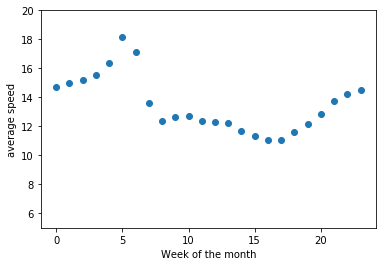

In [14]:
meanspeed_by_hour = df.groupby("pickup_hour")["average_speed"].mean()
plt.gcf().clear()
plt.plot(range(0,24),meanspeed_by_hour,"o")
plt.xlabel("Week of the month")
plt.ylabel("average speed")
plt.ylim([5,20])
plt.show()

** Perform Hypothesis test to determine if the trip speed distribution are materially the same for all hours of day**

**Null hypothesis: speed distribution between two weeks are the same.**

* From the test, we see that p_value between hour pairs (8,11),(8,12),(9,10),(13,19),(16,17) is larger than 0.05, thus we failed to reject the Null hypothesis, i.e., speed distribution between these pairs are the same with high confidence.

* For all the other pairs, p_value is very close to zero, thus we can reject the Null hypothesis, i.e, speed distributions are different. 

In [15]:
test = []
for i in range(24):
    for j in range(24):
        if j!=i:
            houri_average_speed = df[df["pickup_hour"]==i+1]["average_speed"]
            hourj_average_speed = df[df["pickup_hour"]==j+1]["average_speed"]
            test.append([i+1,j+1,stats.ttest_ind(houri_average_speed, hourj_average_speed).pvalue])

In [16]:
for testi in test:
    if testi[-1] > 0.05:
        print testi[:-1]

[8, 11]
[8, 12]
[9, 10]
[10, 9]
[11, 8]
[12, 8]
[13, 19]
[16, 17]
[17, 16]
[19, 13]
